# Singapore Public Housing (HDB) Resale Price Prediction Model (Part 7)
### EDA and Modelling

## 1. About this Notebook

We have finally come to the last chapter of the 7-part project, all the datasets are now cleaned and complete. We may proceed with the exploratory data analysis or EDA here in this notebook to find out how each of the features - that we have collected or engineered throughout the previous parts - affect the property pricing of HDB resale flats. A hexagon map with overlays are also plotted in the Mapping section to illustrate geographically the possible amenities that influences the value of a property.

Feature selection will be carried out as we move along the EDA as part of the strategy to eliminate visibly unnecessary or non-correlated features before the modelling attempt. This could clear out some white noises when we come to the correlation heatmap, which would be plotted to dissect any collinear features.

After we have got the shortlisted features, we will move into the modelling and evaluation part. There are 3 major techniques that will be used for the modelling attempt: (1) Linear Regression, (2) Tree-based Regressor and (3) Neural Network. After the models have been optimized and assessed, a best model will be chosen to be exported for the deployment of a web application.

## 2. Problem Statement

Singapore has always had one of the most expensive housing market in the world, so it becomes crucial for the locals to make sure every dollar they spent are worthwhile. However, most of the housing price are still benchmarked manually by experienced appraiser today. Hence, it would really be helpful for home buyer if there is a predictive model available to find out any undervalued property listing and maximize their savings.

## 3. Initialization

In [1]:
# Vanilla Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, joblib, requests

# Mapping Library
import folium

# plt.style.use('dark_background')

pd.set_option('max_columns', 99)

In [2]:
# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Neural Network Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Core Dataset
hdb = pd.read_csv('./Dataset/final_data.csv')

# Mapping Dataset
hex_df = pd.read_csv('./Dataset/final_data_with_hex.csv')

# Supplementary Dataset
mrt = pd.read_csv('./Dataset/Engineered/MRT.csv')
pri = pd.read_csv('./Dataset/Engineered/Primary_School.csv')[:20]
sec = pd.read_csv('./Dataset/Engineered/Secondary_School.csv')[:20]
spm = pd.read_csv('./Dataset/Engineered/Mall.csv')

In [5]:
# Sanity check on HDB core data
hdb.sample(5)

town  flat_type  storey_range  floor_area_sqm  \
64825  BUKIT BATOK     3 ROOM             2            73.0   
36967        BEDOK     5 ROOM             2           139.0   
40918  BUKIT MERAH     4 ROOM            17            93.0   
30084    WOODLANDS  EXECUTIVE             8           131.0   
46464    SERANGOON     4 ROOM             8            93.0   

               flat_model  lease_commence_date  remaining_lease  resale_price  \
64825             Model A                 1985            64.08      242000.0   
36967  Model A-Maisonette                 1984            64.75      570000.0   
40918             Model A                 2013            93.17      765000.0   
30084           Apartment                 2000            81.08      538000.0   
46464      New Generation                 1985            65.17      475000.0   

       sold_year  sold_month                  address  latitude   longitude  \
64825       2020           1  177 BT BATOK WEST AVE 8  1.346344  103.741742   
36967       2018          10   722 BEDOK RESERVOIR RD  1.336637  103.928208   
40918       2018          12         127D KIM TIAN RD  1.281120  103.829943   
30084       2018           6      670 WOODLANDS DR 71  1.438826  103.799297   
46464       2019           3      215 SERANGOON AVE 4  1.357903  103.872967   

       raffles_place_dist  one_north_dist  jurong_east_dist  orchard_dist  \
64825               41.08           33.93             13.32         40.30   
36967               34.47           57.60             65.45         48.65   
40918               19.50           28.78             41.00         28.62   
30084               46.40           49.72             36.20         42.37   
46464               27.58           38.25             50.40         26.92   

       changi_dist  raffles_place_drive  one_north_drive  jurong_east_drive  \
64825        69.52                26.82            18.72               4.68   
36967        25.40                23.70            31.63              33.78   
40918        51.60                 7.83            12.78              21.18   
30084        64.32                34.65            35.42              30.47   
46464        45.95                18.17            26.47              29.95   

       orchard_drive  changi_drive  mrt_dist      mrt_station  near_bus_itc  \
64825          23.75         43.28     982.0      Bukit Batok           0.0   
36967          20.15         17.52     517.0  Bedok Reservoir           0.0   
40918          10.50         32.83     611.0      Tiong Bahru           0.0   
30084          31.10         40.83     252.0        Admiralty           0.0   
46464          14.63         29.43     787.0        Serangoon           0.0   

       near_mrt_itc  bus_u300m  bus_dist  mall_u1km  mall_dist  pri_u1km  \
64825           0.0        4.0      97.0        1.0      915.0       2.0   
36967           0.0        4.0     251.0        0.0     1187.0       4.0   
40918           0.0        4.0     200.0        1.0      670.0       2.0   
30084           0.0        4.0     223.0        3.0      301.0       6.0   
46464           0.0        6.0     109.0        2.0      813.0       2.0   

       pri_u2km  pri_aff_u1km  pri_aff_u2km  pri_elite_u1km  pri_elite_u2km  \
64825       8.0           0.0           0.0             0.0             0.0   
36967      10.0           0.0           0.0             2.0             3.0   
40918       8.0           0.0           0.0             0.0             0.0   
30084      10.0           0.0           0.0             1.0             1.0   
46464       9.0           0.0           0.0             0.0             1.0   

       sec_u1km  sec_u2km  sec_aff_u1km  sec_aff_u2km  sec_elite_u1km  \
64825       1.0       7.0           0.0           0.0             0.0   
36967       2.0       8.0           0.0           0.0             0.0   
40918       1.0       5.0           0.0           0.0             0.0   
30084       3.0       6.0           

In [6]:
# Sanity check on Map data
hex_df.sample(5)

address  storey_range  floor_area_sqm  \
8073      831 TAMPINES ST 83      2.000000       75.666667   
4032          35 MARINE CRES      6.714286       73.571429   
1434     169 BEDOK STH AVE 3      6.500000       83.000000   
3071  280B SENGKANG EAST AVE      9.875000      102.000000   
1314        160 BISHAN ST 13      2.000000      144.000000   

      lease_commence_date  remaining_lease   resale_price    sold_year  \
8073               1986.0        67.098333  334388.833333  2017.666667   
4032               1975.0        55.760000  403214.285714  2018.428571   
1434               1985.0        65.937500  387000.000000  2018.000000   
3071               2015.0        94.884375  614055.500000  2019.312500   
1314               1987.0        68.420000  801000.000000  2018.000000   

      sold_month  latitude   longitude  raffles_place_dist  one_north_dist  \
8073    8.166667  1.350363  103.934555               35.90           57.30   
4032    4.571429  1.303781  103.912903               32.30           53.87   
1434    4.000000  1.320389  103.945094               28.03           50.43   
3071    5.937500  1.386162  103.892092               30.58           44.12   
1314    3.000000  1.346928  103.856354               27.70           32.98   

      jurong_east_dist  orchard_dist  changi_dist  raffles_place_drive  \
8073             71.88         47.15        26.12                26.88   
4032             66.48         40.87        36.60                14.92   
1434             64.32         39.28        15.20                21.77   
3071             56.53         32.17        47.82                24.77   
1314             46.85         23.67        46.72                16.48   

      one_north_drive  jurong_east_drive  orchard_drive  changi_drive  \
8073            34.82              36.98          23.23         18.30   
4032            25.82              32.15          18.52         17.78   
1434            32.67              38.22          24.58         16.00   
3071            33.07              36.55          21.12         23.30   
1314            23.22              26.95          12.88         29.72   

      mrt_dist  near_bus_itc  near_mrt_itc  bus_u300m  bus_dist  mall_u1km  \
8073     661.0           0.0           0.0        9.0      63.0        1.0   
4032    1907.0           0.0           0.0        6.0      71.0        4.0   
1434     724.0           0.0           0.0        7.0      93.0        0.0   
3071     419.0           1.0           0.0       12.0      75.0        2.0   
1314     904.0           0.0           0.0        3.0     177.0        2.0   

      mall_dist  pri_u1km  pri_u2km  pri_aff_u1km  pri_aff_u2km  \
8073      763.0       3.0      12.0           0.0           0.0   
4032      879.0       2.0       5.0           0.0           0.0   
1434     1273.0       2.0       5.0           0.0           0.0   
3071      733.0       6.0      17.0           0.0           0.0   
1314      923.0       4.0      12.0           0.0           1.0   

      pri_elite_u1km  pri_elite_u2km  sec_u1km  sec_u2km  sec_aff_u1km  \
8073             1.0             3.0       3.0       8.0           0.0   
4032             0.0             0.0       2.0       6.0           0.0   
1434             1.0             2.0       3.0       7.0           0.0   
3071             0.0             1.0       3.0      12.0           0.0   
1314             0.0             2.0       3.0       8.0           0.0   

      sec_aff_u2km  sec_elite_u1km  sec_elite_u2km  dist_to_highway  \
8073           0.0             0.0             0.0           1468.0   
4032           1.0             0.0             1.0            142.0   
1434           0.0             0.0             0.0            856.0   
3071           0.0             0.0             0.0           1412.0   
1314           2.0             0.0             3.0            258.0   

      dist_to_exits  price_per_sqft  unit_price  elem_price  hex_id  \
8073         1081.0     4431.546493

In [7]:
# Renaming columns to be more self-explanatory
rename_fr_cols = [col for col in hdb.columns if '_dist' in col][:-3]
rename_to_cols = [col.replace('dist', 'pt') for col in rename_fr_cols]
rename_cols = {ft: to for ft, to in zip(rename_fr_cols, rename_to_cols)}

hdb.rename(columns = rename_cols, inplace=True)

In [8]:
# Sanity check on the column name change
hdb.columns

Index(['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price', 'sold_year',
       'sold_month', 'address', 'latitude', 'longitude', 'raffles_place_pt',
       'one_north_pt', 'jurong_east_pt', 'orchard_pt', 'changi_pt',
       'raffles_place_drive', 'one_north_drive', 'jurong_east_drive',
       'orchard_drive', 'changi_drive', 'mrt_dist', 'mrt_station',
       'near_bus_itc', 'near_mrt_itc', 'bus_u300m', 'bus_dist', 'mall_u1km',
       'mall_dist', 'pri_u1km', 'pri_u2km', 'pri_aff_u1km', 'pri_aff_u2km',
       'pri_elite_u1km', 'pri_elite_u2km', 'sec_u1km', 'sec_u2km',
       'sec_aff_u1km', 'sec_aff_u2km', 'sec_elite_u1km', 'sec_elite_u2km',
       'dist_to_highway', 'dist_to_exits'],
      dtype='object')

In [9]:
hdb.shape

(70104, 45)

As performed before on the mapping dataset during Part 6, we will carry out the same feature engineering on the core dataset and create 3 different type of price metrics:

1. **price_per_sqft** - The simplest form of unit price in the real estate market
2. **unit_price** - It is the price_per_sqft divided by the remaining year lease, eliminating the effect of property lease
3. **elem_price** - Price metric that is more elementary than the unit_price where it has factored in the effect of storey range as well

We would also remove Terrace HDB houses from the dataset as they proved to be outliers as contrary to the general HDB flats. They are extremely rare in Singapore, in fact only 2 neighbourhoods are captured in the dataset. The inclusion would have negligible effect on the model accuracy as the sample size is too low.

In [10]:
# Remove terrace-house (outliers) from dataset for better mapping visualization
hdb = hdb[hdb['flat_model']!='Terrace'].reset_index(drop=True)

# Price per square feet
hdb['price_per_sqft'] = hdb['resale_price'] / hdb['floor_area_sqm'] * 10.7639

# Unit Price --- Price per area per year lease
hdb['unit_price'] = hdb['price_per_sqft'] / hdb['remaining_lease']

# Elementary Price --- Price per area per year lease per storey level
hdb['elem_price'] = hdb['unit_price'] / hdb['storey_range']

In [11]:
hdb.shape

(70063, 48)

# 4. Exploratory Data Analysis (EDA)

## 4.1 Flat Types

The public housing or HDB in Singapore is generally categorized based on the number of rooms it has, for example, 3-room, 4-room and 5-room are the most common type available in the market. In the bar chart plotted below, we can see the distribution of each type. The blue represents the demand, which is derived from the core HDB dataset; while the orange represents supply, extracted from the [national data archive](https://data.gov.sg/dataset/number-of-residential-units-under-hdb-s-management) with housing supply data spanning from 2008 up to 2019.

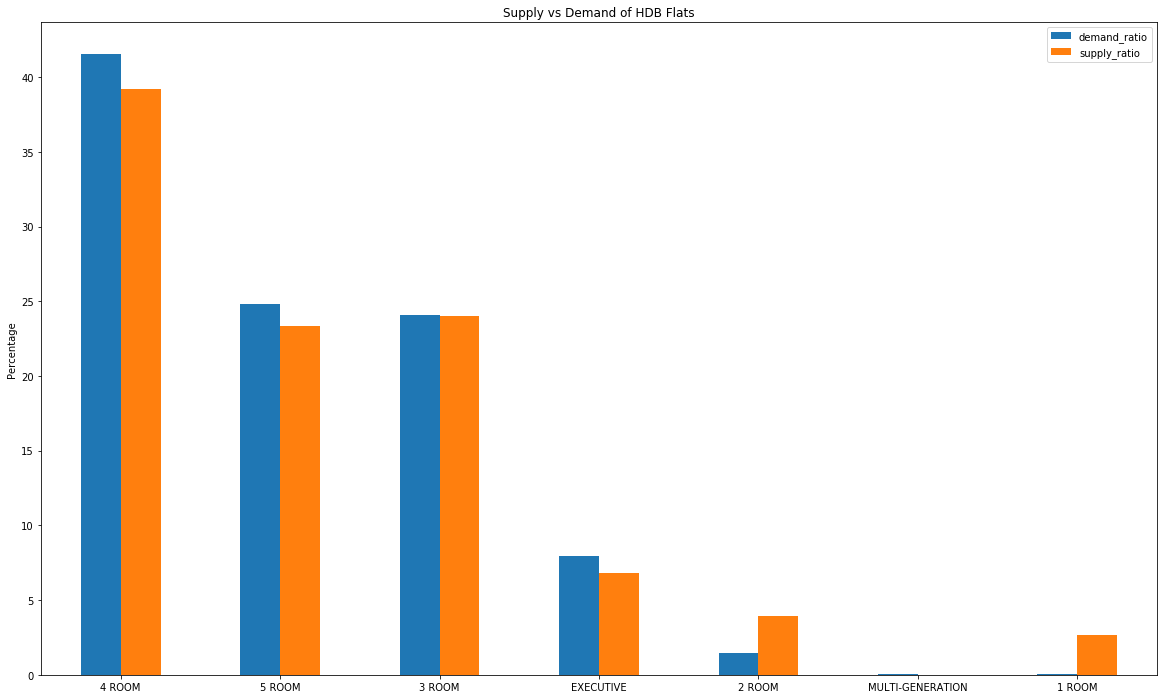

In [12]:
response = requests.get("https://data.gov.sg/api/action/datastore_search?resource_id=34b7e3fe-b3b9-4f08-a5ca-c8574f13ccbd&limit=7254")
supply_df = pd.DataFrame(response.json()['result']['records'], dtype='float')
supply_df = supply_df.groupby('flat_type').sum()[['no_of_dwelling_units']]
supply_df.index = supply_df.index.str.replace('-', ' ').str.upper()
supply_df.drop(['HUDC', 'STUDIO APARTMENT'], inplace=True)
supply_df.loc['MULTI-GENERATION', 'no_of_dwelling_units'] = 0
supply_df['supply_ratio'] = round(supply_df['no_of_dwelling_units'] / supply_df['no_of_dwelling_units'].sum(), 4) * 100
supply_df = pd.DataFrame(supply_df['supply_ratio'])

flat_type = pd.DataFrame(round(hdb['flat_type'].value_counts(normalize=True) * 100, 2))
flat_type.columns = ['demand_ratio']
pd.merge(flat_type, supply_df, left_index=True, right_index=True).plot(kind='bar', figsize=(20, 12))
plt.xticks(rotation=0)
plt.ylabel('Percentage')
plt.title('Supply vs Demand of HDB Flats')
plt.show()

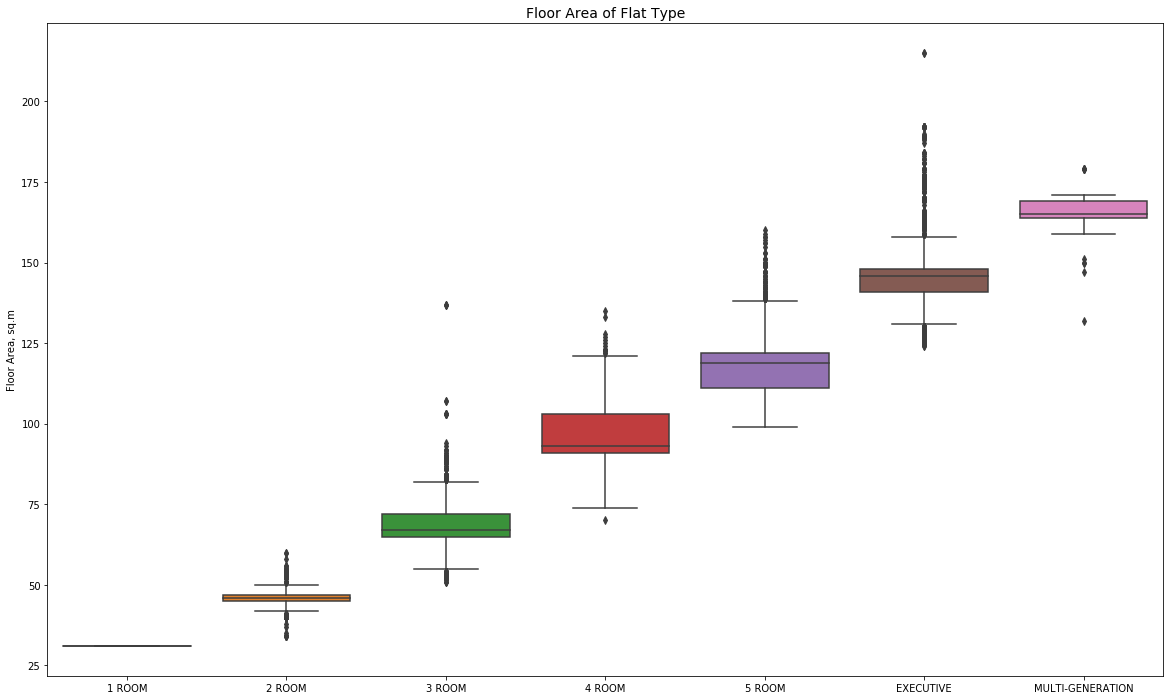

In [13]:
plt.figure(figsize=(20, 12))
sns.boxplot(data=hdb, y='floor_area_sqm', x='flat_type', order=sorted(hdb.flat_type.unique()))
plt.xlabel("")
plt.ylabel('Floor Area, sq.m')
plt.title("Floor Area of Flat Type", fontsize=14)
plt.show()

From the distribution of flat type shown above, most of the transaction are 4-room flats, covering a staggering 41 percent of the entire dataset. Next up would be 5-room and 3-room, both at 24 percent. The rest of the type are relatively rare. It might be due low demand from the public for the case of 1-room and 2-room flat as they might be deemed too small for home-buyer that are looking to form any sort of family nucleus.

Nevertheless, we would like to take flat type out of the equation as the variance can be perfected justified by floor area, which is a numerical data and thus more quantifiable.

In [14]:
# Drop off Flat Type
hdb.drop('flat_type', axis=1, inplace=True)

### 4.2 Sold Month and Year

In [15]:
# Checking for demand throughout the years
monthly_transaction = hdb.groupby('sold_year').agg({'resale_price': 'count', 'sold_month': 'max'})
monthly_transaction['monthly_transaction'] = (monthly_transaction['resale_price'] / monthly_transaction['sold_month']).astype(int)
monthly_transaction.columns = ['Sale Count', 'Month Count', 'Monthly Sale Count']
monthly_transaction

Sale Count  Month Count  Monthly Sale Count
sold_year                                             
2017            20497           12                1708
2018            21863           12                1821
2019            22175           12                1847
2020             5528            3                1842

From the table above, we can see that the monthly transaction or resale count is almost constant through the period of 3 years and 3 months. However, if you look the figure below where the unit price is plotted against the sold month, we can see that there is almost no seasonality of sale price fluctuating with accordance to the month. But there is a general pattern where the sale price does dropped slightly throughout the period that we are studying. The effect is comparatively minor and might be caused by the economic climate in Singapore and regional Asia Pacific, which is difficult to be captured by the machine learning model.

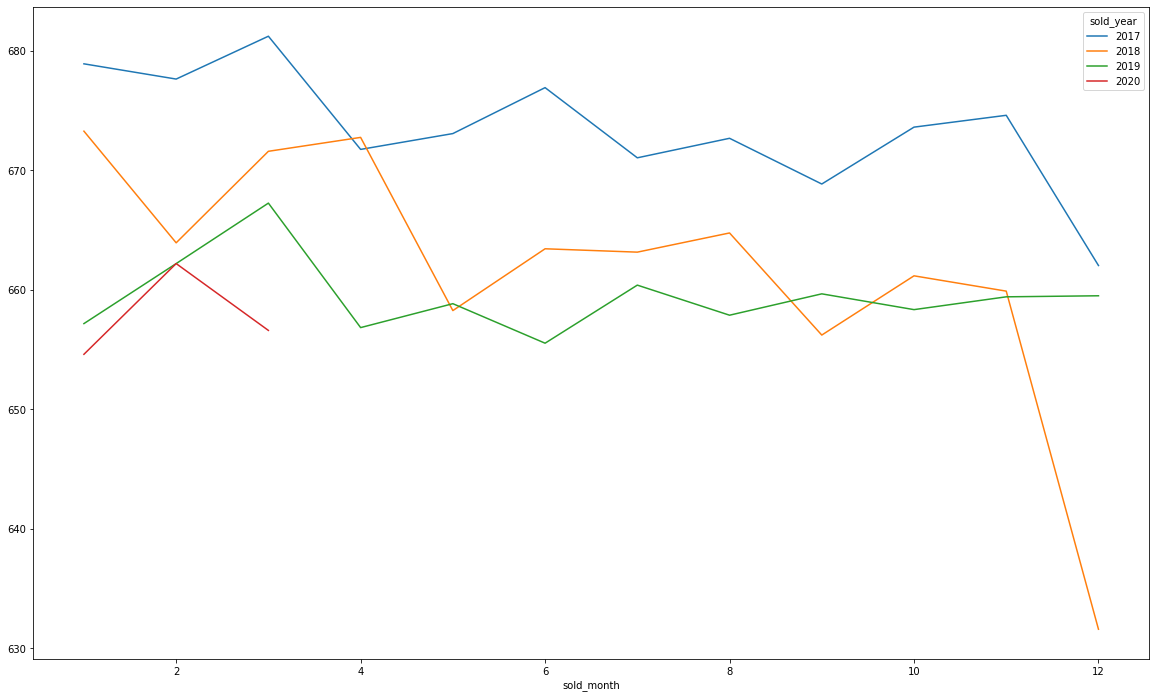

In [16]:
# Checking for seasonality
hdb.pivot_table(index='sold_month', columns='sold_year', aggfunc='mean')['unit_price'].plot(figsize=(20, 12))
plt.show()

In [17]:
# Drop off sold_month
hdb.drop('sold_month', axis=1, inplace=True)

### 4.3 Floor Area

In [18]:
# Function to create line plot with data resampled according to the granularity (compound)
def compound_line_plot(compound, x, x_2=None, mode='mean', y='price_per_sqft', 
                       df=hdb, x_label=None, y_label=None, title=None, cutoff_point=None):
    
    fig, ax = plt.subplots(figsize=(20,10))
    
    if mode == 'mean':
        temp = df.groupby(x).mean()
        temp = temp.groupby(temp.index // compound).mean().reset_index()[[x, y]]
    else:
        temp = df.groupby(x).median()
        temp = temp.groupby(temp.index // compound).median().reset_index()[[x, y]]
        
    temp[x] = temp[x] * compound
    
    if cutoff_point:
        temp = temp[temp[x] <= cutoff_point]
    temp.set_index(x).plot(ax=ax)
    
    if x_2:
        if mode == 'mean':
            temp_2 = df.groupby(x_2).mean()
            temp_2 = temp_2.groupby(temp_2.index // compound).mean().reset_index()[[x_2, y]]
        else:
            temp_2 = df.groupby(x_2).median()
            temp_2 = temp_2.groupby(temp_2.index // compound).median().reset_index()[[x_2, y]]
        temp_2[x_2] = temp_2[x_2] * compound
        if cutoff_point:
            temp_2 = temp_2[temp_2[x_2] <= cutoff_point]
        temp_2.set_index(x_2).plot(ax=ax)
        ax.legend([x.replace('_', ' ').title(), x_2.replace('_', ' ').title()])
    else:
        ax.get_legend().remove()
    
    if x_label == None:
        plt.xlabel(x.replace('_', ' ').title(), fontsize=12)
    else:
        plt.xlabel(x_label, fontsize=12)

    if y_label == None:
        plt.ylabel(y.replace('_', ' ').title(), fontsize=12)
    else:
        plt.ylabel(y_label, fontsize=12)
    
    if title:
        plt.title(title, fontsize=15)
    else:
        title = y + ' vs ' + x
        plt.title(title.replace('_', ' ').title(), fontsize=15)
        
    plt.show()

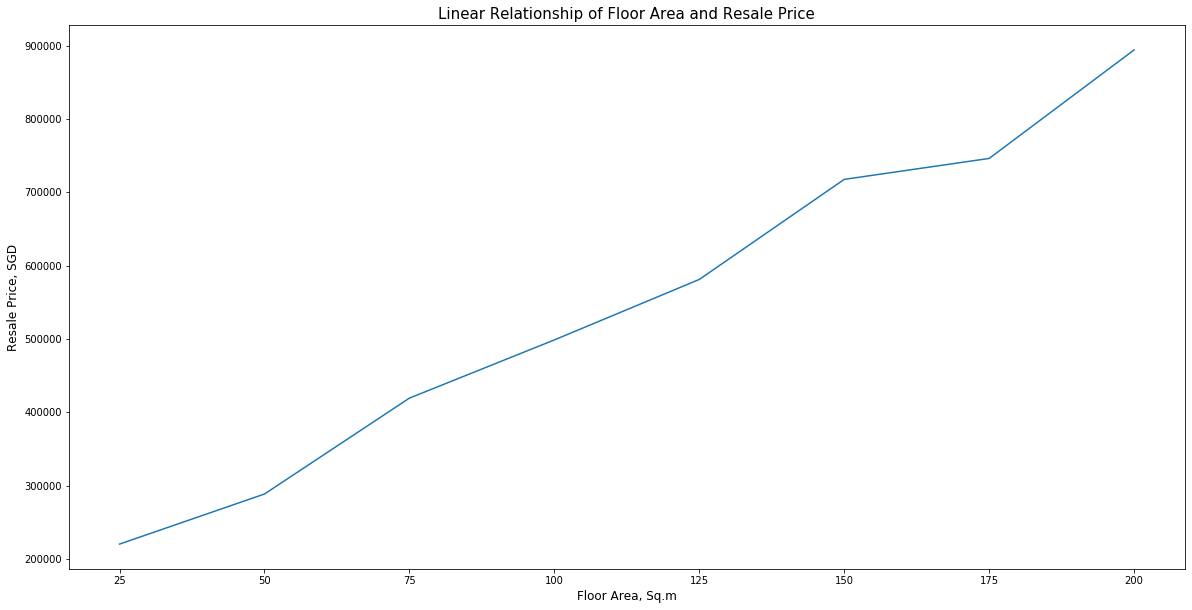

In [19]:
compound_line_plot(compound=25, x="floor_area_sqm", y="resale_price", mode='mean',
                    x_label="Floor Area, Sq.m", y_label="Resale Price, SGD" , 
                    title="Linear Relationship of Floor Area and Resale Price")

As shown in the figure above, we can see that there is a very clear linear relationship between floor area and sale price. It comes at no surprises as most real estate in the world adhere to this rule. We may also see that a typical HDB range from 25 sq.m up to 200 sq.m, which are of tremendous difference.

### 4.4 Floor Level

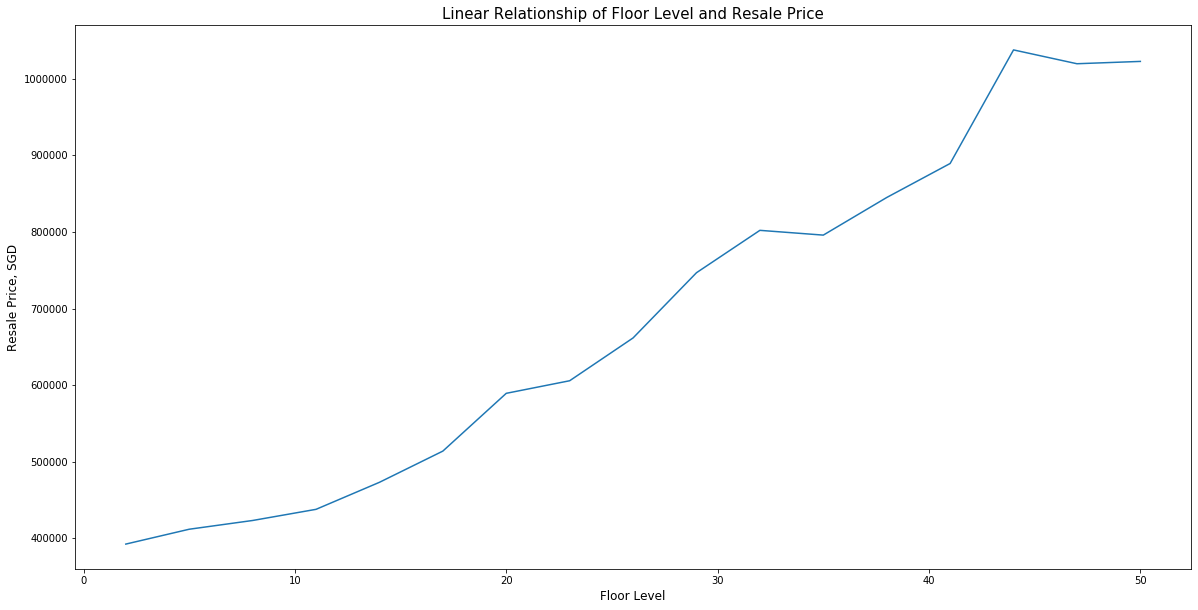

In [20]:
compound_line_plot(compound=1, x="storey_range", y="resale_price", mode='mean',
                    x_label="Floor Level", y_label="Resale Price, SGD" , 
                    title="Linear Relationship of Floor Level and Resale Price")

Floor level where the property is located has a linear relationship with the sale price as well. It seems the market are willing to pay for premium to stay at a higher storey, probably for the view, the airflow, or to be away from the street-level noise. One thing worth noting is that the price has gone stagnant after about 45 storeys, however there are actually 2 HDB neighbourhood in Singapore that are over 40 storeys high - which are at Duxton Hill and Dawson respectively. So the supply is extremely rare and sample size is too low to judge the stagnation.

### 4.5 Remaining Year Lease

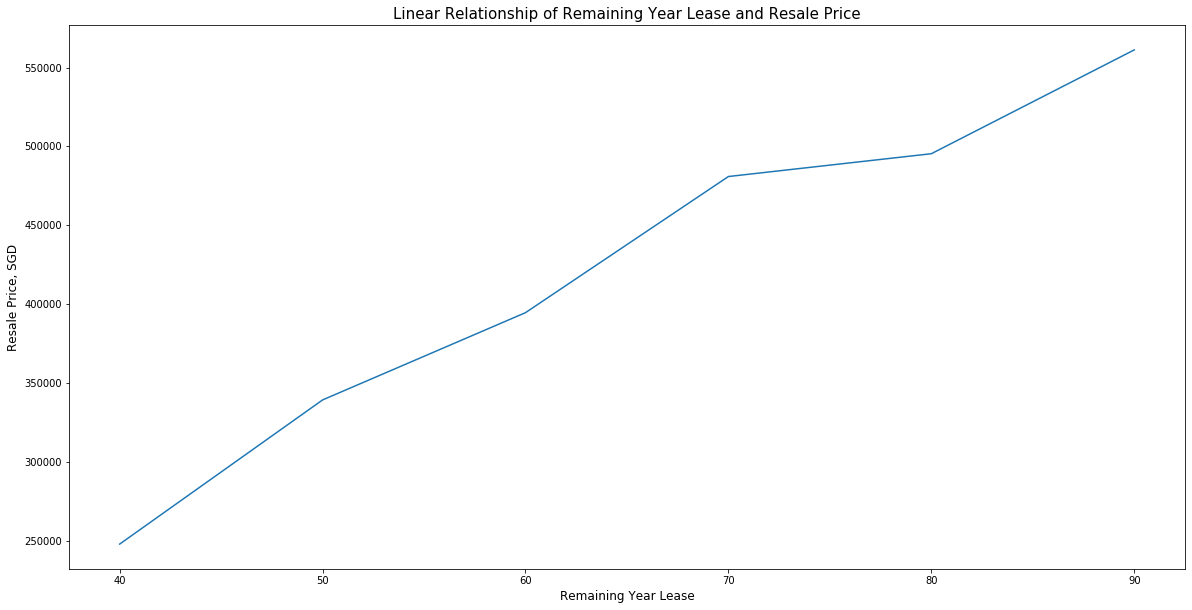

In [21]:
compound_line_plot(compound=10, x="remaining_lease", y="resale_price", mode='mean',
                    x_label="Remaining Year Lease", y_label="Resale Price, SGD" , 
                    title="Linear Relationship of Remaining Year Lease and Resale Price")

Similar to the floor area and floor level, remaining year lease of a unit has also exhibited linear relationship with the resale price. All HDB units in Singapore are subjected to a strict 99-year-lease, property ownership will be relinquished to the government at the expiration of the lease for future development. Hence, it is only natural for the market to pay more for newer houses.

### 4.6 Transporation

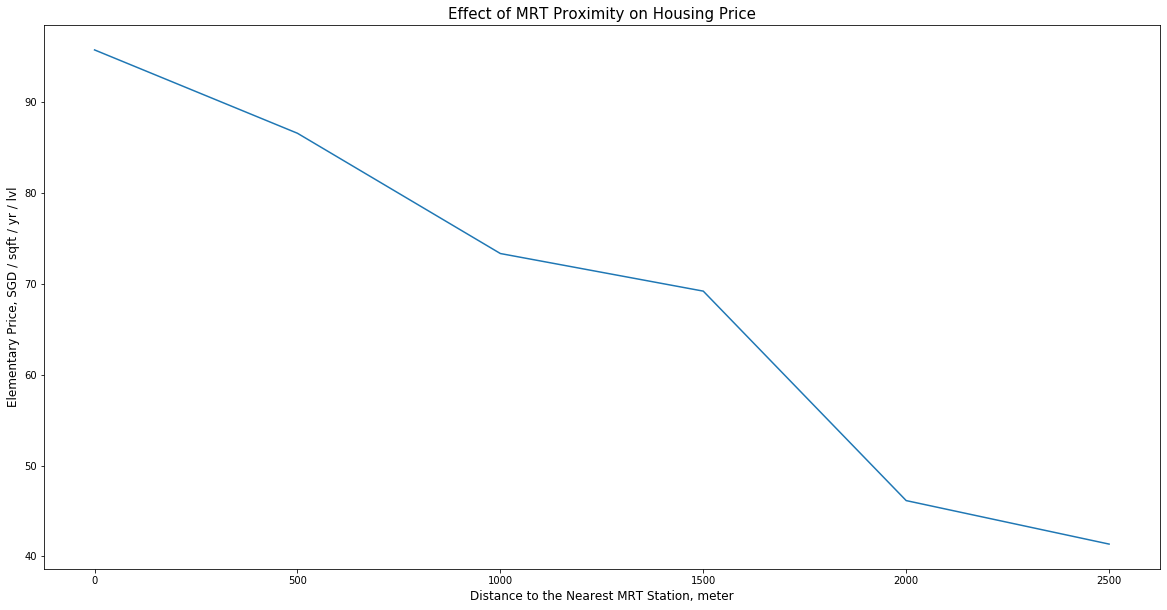

In [22]:
compound_line_plot(compound=500, x="mrt_dist", y='elem_price', mode='median', cutoff_point=2500,
                    x_label="Distance to the Nearest MRT Station, meter", 
                    y_label="Elementary Price, SGD / sqft / yr / lvl" , 
                    title="Effect of MRT Proximity on Housing Price")

Now if we look at how prices fluctuate with increment in distance from the nearest MRT station, it comes at no surprise that the prices drop significantly as the distance gets further. For the comparison, instead of plotting the distance with pure resale price, we are choosing the elementary price to see the effect. It is so that we can take away the effect of floor area, year lease and storey. Area near the MRT station are more prone to re-development and are thus newer in comparison. These units tend to have smaller area and higher level. So the effect would be clearer if we strip those factors away.

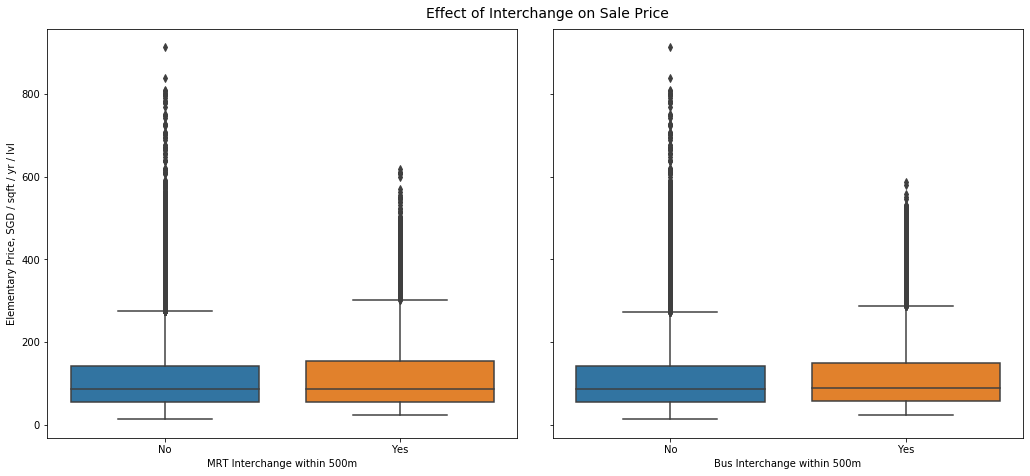

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharey=True)
sns.boxplot(data=hdb, y='elem_price', x='near_mrt_itc', ax=ax[0])
ax[0].set_xlabel("MRT Interchange within 500m")
ax[0].set_ylabel('Elementary Price, SGD / sqft / yr / lvl')
ax[0].set_xticklabels(["No", "Yes"])
sns.boxplot(data=hdb, y='elem_price', x='near_bus_itc', ax=ax[1])
ax[1].set_xlabel("Bus Interchange within 500m")
ax[1].set_ylabel('')
ax[1].set_xticklabels(["No", "Yes"])
plt.tight_layout(h_pad=0.25, pad=3.2)
fig.suptitle("Effect of Interchange on Sale Price", fontsize=14, x=0.53)
plt.show()

Now if we compare the effect of proximity to MRT or Bus interchange, we can see that there is negligible effect. The positive and negative class are almost inseparable. As such, we will drop these 2 columns from the analysis as it would not be able address any unexplained variance by the other features.

In [24]:
hdb.drop(['near_mrt_itc', 'near_bus_itc'], axis=1, inplace=True)

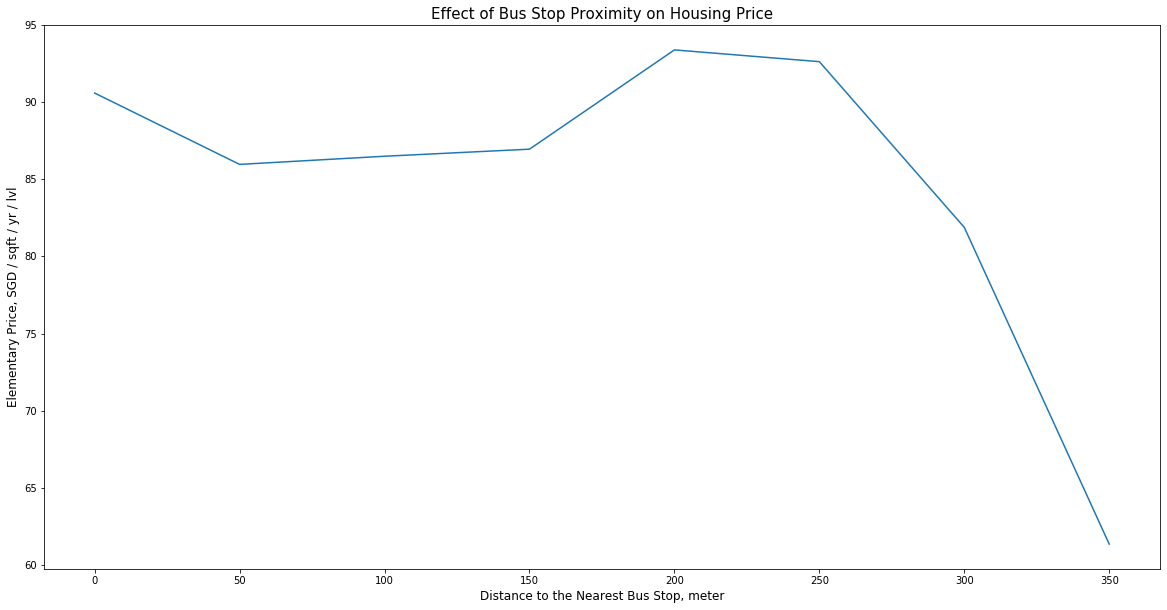

In [25]:
compound_line_plot(compound=50, x="bus_dist", y='elem_price', mode='median',
                    x_label="Distance to the Nearest Bus Stop, meter", 
                    y_label="Elementary Price, SGD / sqft / yr / lvl" , 
                    title="Effect of Bus Stop Proximity on Housing Price")

In [26]:
print("Percentage of Entries >300m away from Bus Stop: ", str(round((hdb['bus_dist']>=300).sum() / hdb.shape[0], 4) * 100) + " %")

Percentage of Entries >300m away from Bus Stop:  0.53 %


As shown in the figure above, the distance to the nearest bus stop is very minor influence to the pricing of a property. Singapore government has developed a very extensive network of public bus system across the city state, thus it is extremely rare for bus stop to be far away from any public housing. However, we are seeing a sharp drop when the distance exceeds 300m (~5 mins walk).

However, these entries only constitute to about 0.53% of the data, which is rather negligible. As such, we will drop the column entirely from the dataset.

In [27]:
hdb.drop('bus_dist', axis=1, inplace=True)

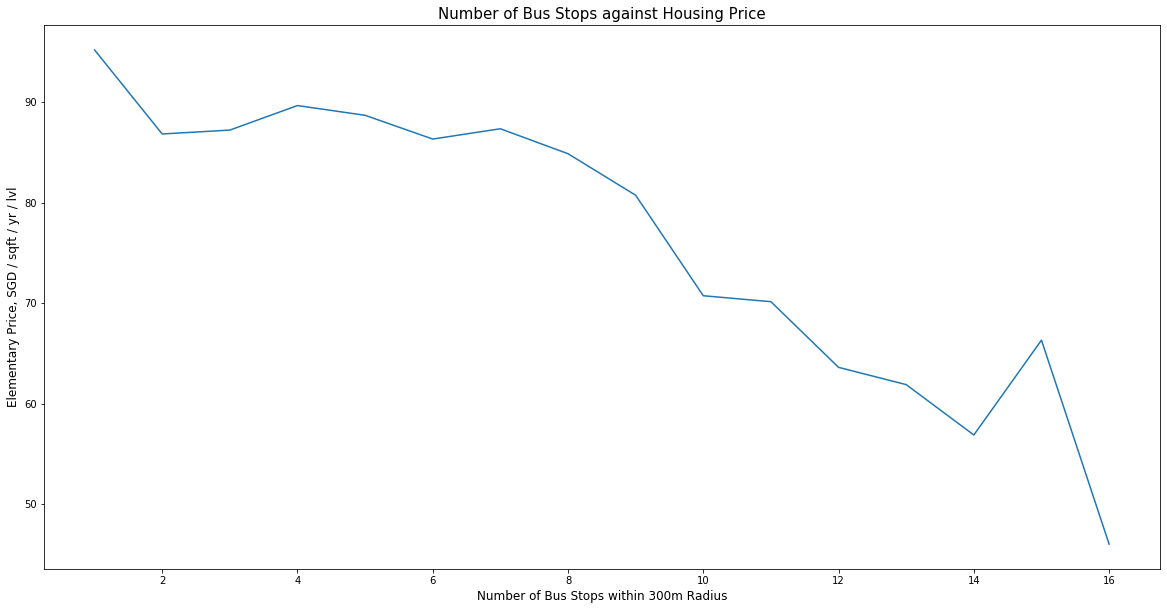

In [28]:
compound_line_plot(compound=1, x="bus_u300m", y='elem_price', mode='median', df=hdb[hdb['bus_u300m']>0],
                    x_label="Number of Bus Stops within 300m Radius", 
                    y_label="Elementary Price, SGD / sqft / yr / lvl" , 
                    title="Number of Bus Stops against Housing Price")

Now if we look into the effect of number of bus stop in close proximity to property pricing, it became counter-intuitive to common sense. It shows that a property actually becomes cheaper if there are more bus stops within walking distance of 300m radius. However, we need to investigate more about this phenomenon to settled on the conclusion of such relationship.

In [29]:
# Function to create twin plots for comparison of effect of feature on 2 targets
# To discover any correlation between features

def twinx_plot(x, y_twin, compound=1, y='elem_price', df=hdb, y_label=None, y_twin_label=None, 
               x_label=None, title=None, cutoff_point=None, x_leg_shift=0):
    temp_df = df.groupby(x).median()
    temp_df = temp_df.groupby(temp_df.index // compound).median().reset_index()[[x, y, y_twin]]
    temp_df[x] = temp_df[x] * compound
    temp_df = temp_df.set_index(x)
    fig, ax = plt.subplots(figsize=(20, 12))
    if cutoff_point:
        temp_df = temp_df[temp_df.index <= cutoff_point]
    ax.plot(temp_df[y], label='Elementary Price')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(temp_df[y_twin], color='orange', label=y_twin_label)

    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax2.set_ylabel(y_twin_label, fontsize=12, rotation=270, labelpad=20)

    ax2.legend(loc=(0.87+x_leg_shift,0.93))
    
    if title:
        plt.title(title, fontsize=15)
    else:
        title = y + ' vs ' + x
        plt.title(title.replace('_', ' ').title(), fontsize=15)
        
    plt.show()

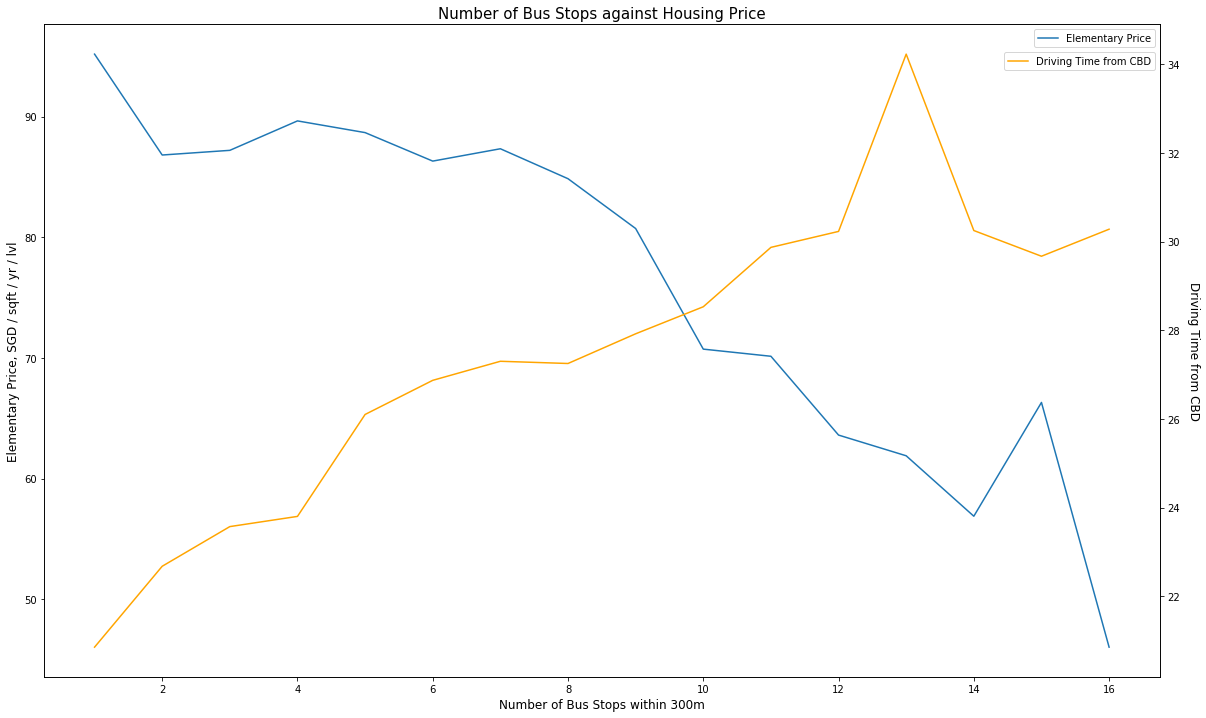

In [30]:
twinx_plot('bus_u300m', 'raffles_place_drive', compound=1, df=hdb[hdb['bus_u300m']>0],
           y_label='Elementary Price, SGD / sqft / yr / lvl', 
           y_twin_label='Driving Time from CBD', x_label='Number of Bus Stops within 300m',
           title='Number of Bus Stops against Housing Price', x_leg_shift=-0.01)

So if we compare the number of bus stop to the proximity from the city center, we can find that as the property gets further away from the city center, it tends to have more bus stops to make up for the lack of train network. Hence this is would not be a good indicator for sale price, we will drop it from the dataset.

In [31]:
hdb.drop('bus_u300m', axis=1, inplace=True)

### 4.7 Shopping Malls

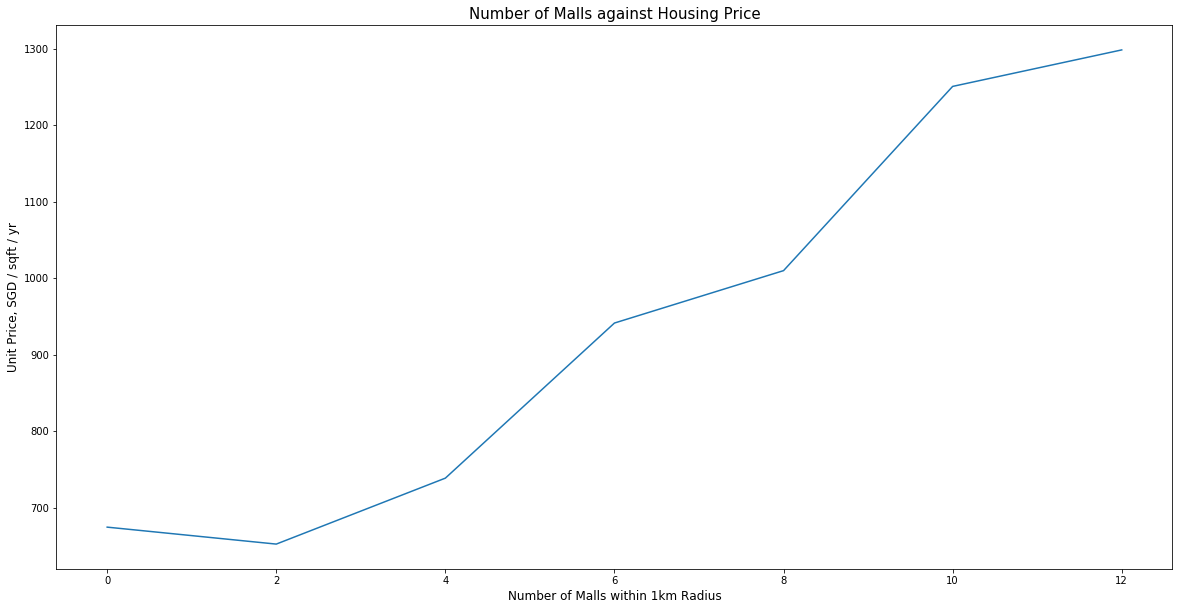

In [32]:
compound_line_plot(compound=2, x="mall_u1km", y='unit_price', cutoff_point=12,
                    x_label="Number of Malls within 1km Radius", 
                    y_label="Unit Price, SGD / sqft / yr", 
                    title="Number of Malls against Housing Price")

From the chart above, we can see that there is a linear relationship between the number of malls within 1km radius and the pricing of a property. However, this maybe due to the fact where high shopping malls concentration usually happen in the City Centre only. If we plotted the travel time from CBD as a measure of proximity to the city - as shown in figure below, we can see that our theory is correct about high concentration of shopping mall. So we would drop this column as well since it can be explained by city proximity.

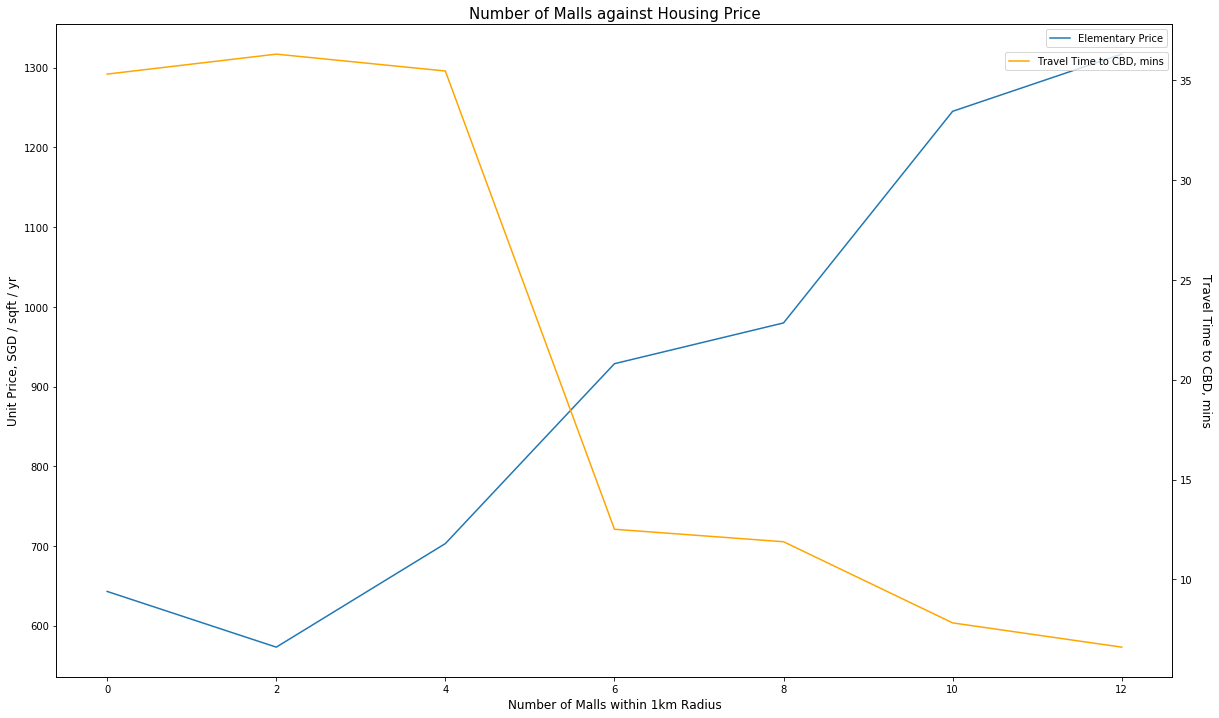

In [33]:
twinx_plot('mall_u1km', 'raffles_place_pt', y='unit_price', compound=2, y_label='Unit Price, SGD / sqft / yr', 
           y_twin_label='Travel Time to CBD, mins', x_label='Number of Malls within 1km Radius', 
           title="Number of Malls against Housing Price", x_leg_shift=-0.02, cutoff_point=12)

In [34]:
hdb.drop('mall_u1km', axis=1, inplace=True)

In [35]:
# def outlier_detector(metric):
#     temp_df = hdb.copy()
#     temp_df['address'] = temp_df['address'].apply(lambda row : ' '.join(row.split()[1:]))
#     temp_df = temp_df.groupby('address').agg({metric: 'mean', 'remaining_lease': 'mean', 'town': 'max'}).reset_index()
#     temp_df = pd.merge(temp_df, hdb.groupby('town').median()[metric], how='left', on='town')
#     temp_df.columns = ['address', metric, 'remaining_lease', 'town', 'regional_' + metric]
#     temp_df['ratio'] = temp_df[metric] / temp_df['regional_' + metric]
#     temp_df = temp_df[['address', 'town', 'remaining_lease', 'ratio']]
#     return temp_df[temp_df['ratio'] >= temp_df.ratio.quantile(0.975)].sort_values('ratio', ascending=False)

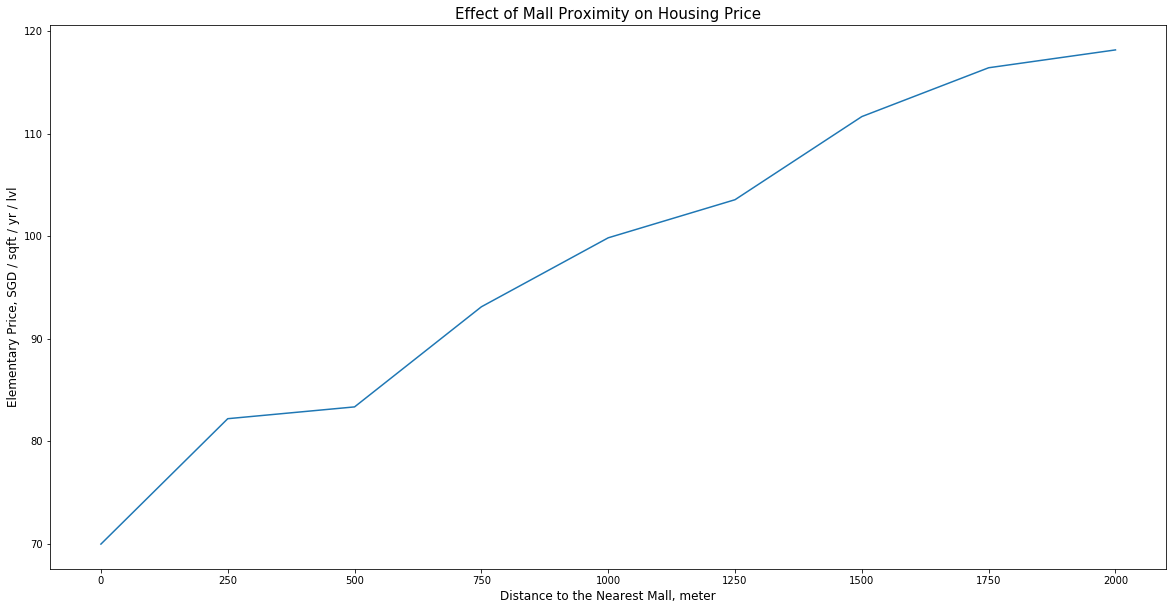

In [36]:
compound_line_plot(compound=250, x="mall_dist", y='elem_price', mode='median', cutoff_point=2000,
                    x_label="Distance to the Nearest Mall, meter", 
                    y_label="Elementary Price, SGD / sqft / yr / lvl", 
                    title="Effect of Mall Proximity on Housing Price")

Here we see that being closer to the mall actually decreases the house value. To double check on this observation, we have plotted it against MRT distance as well as most shopping malls actually cluster around MRT station in Singapore. However, it has shown that they are not highly correlated. So for this case, we will keep the feature.

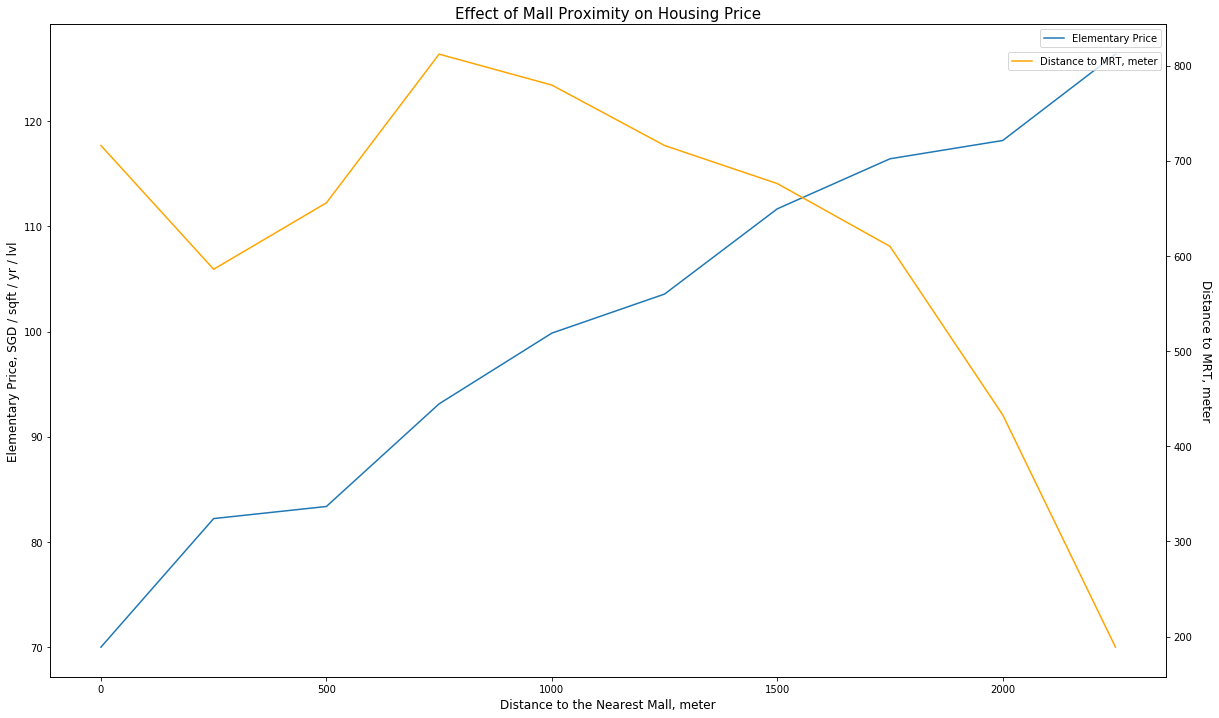

In [37]:
twinx_plot('mall_dist', 'mrt_dist', y='elem_price', compound=250, y_label='Elementary Price, SGD / sqft / yr / lvl', 
           y_twin_label='Distance to MRT, meter', x_label='Distance to the Nearest Mall, meter', 
           title="Effect of Mall Proximity on Housing Price", x_leg_shift=-0.012, cutoff_point=2500)

### 4.8 Education Institution

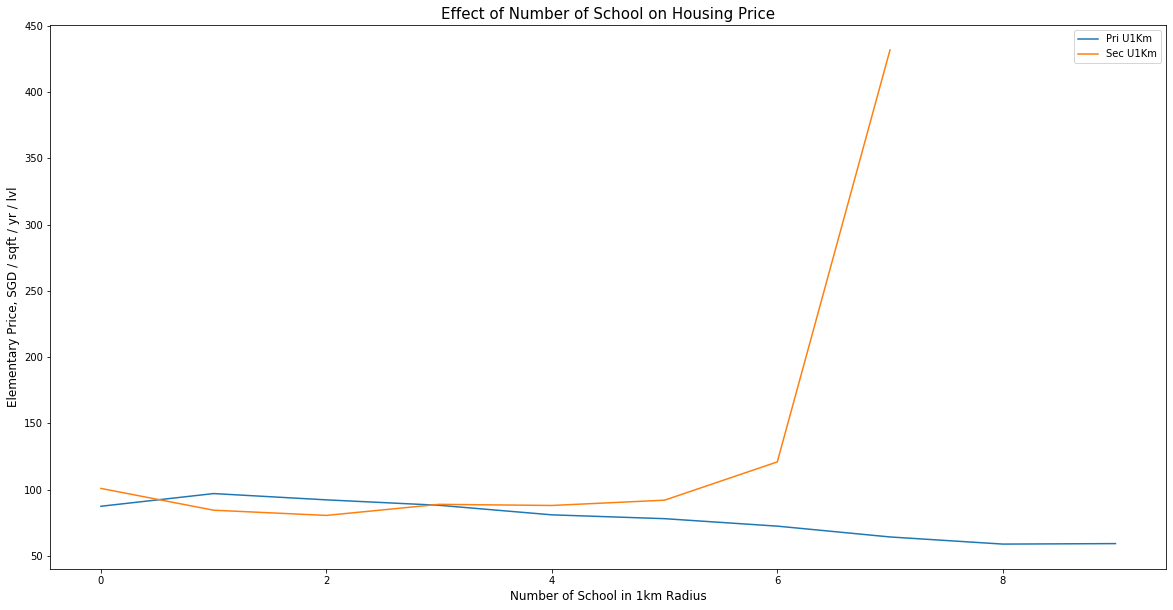

In [38]:
compound_line_plot(compound=1, x="pri_u1km", x_2="sec_u1km", y='elem_price', mode='median',
                    x_label="Number of School in 1km Radius", 
                    y_label="Elementary Price, SGD / sqft / yr / lvl", 
                    title="Effect of Number of School on Housing Price")

In [39]:
hdb[hdb['sec_u1km']==7].address.value_counts()

503 BISHAN ST 11    5
Name: address, dtype: int64

From the comparison above, we can see that the price spiked at 7 secondary schools, however, it only applies to 5 transactions. All of the transactions are at the same neighbourhood in Bishan. So this effect not justiable due to the small sample size. Apart from the anomalies, the other results seems to be relatively constant as the number of school increases. So we can confirm that these 2 features are relatively weak, we will drop them from the dataset.

In [40]:
hdb.drop(['sec_u1km', 'pri_u1km'], axis=1, inplace=True)

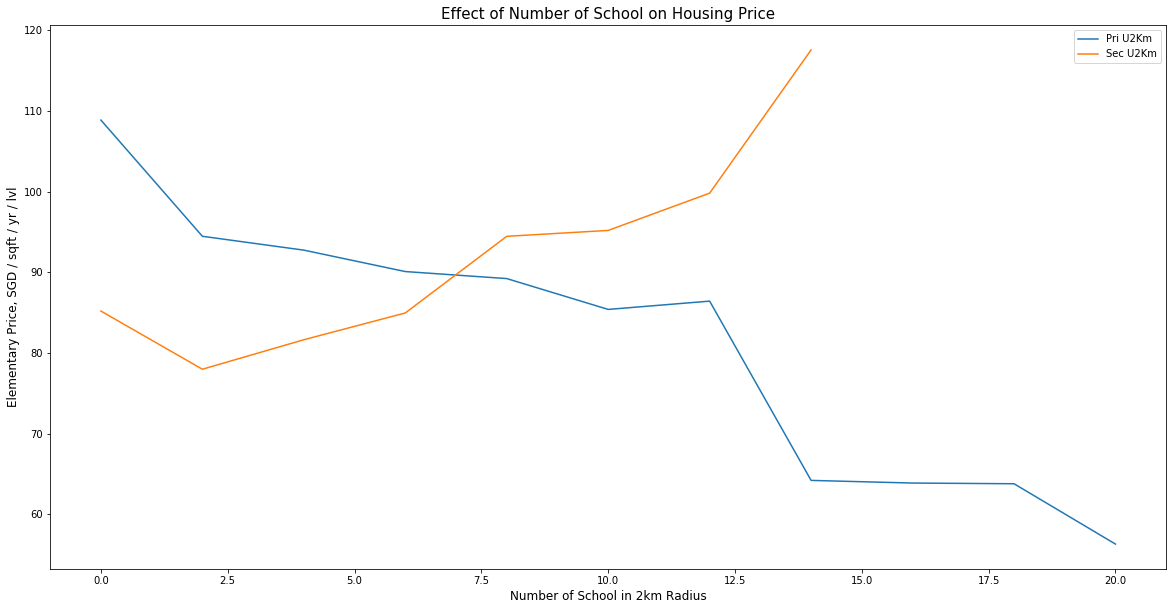

In [41]:
compound_line_plot(compound=2, x="pri_u2km", x_2="sec_u2km", y='elem_price', mode='median',
                    x_label="Number of School in 2km Radius", 
                    y_label="Elementary Price, SGD / sqft / yr / lvl", 
                    title="Effect of Number of School on Housing Price")

As contrary to the 1km radius search, the 2km radius has yielded some observable pattern. The market are generally willing to pay a premium to stay close to school district, however it only applies to secondary school. For primary school, it seems to have an opposite effect on the house prices.

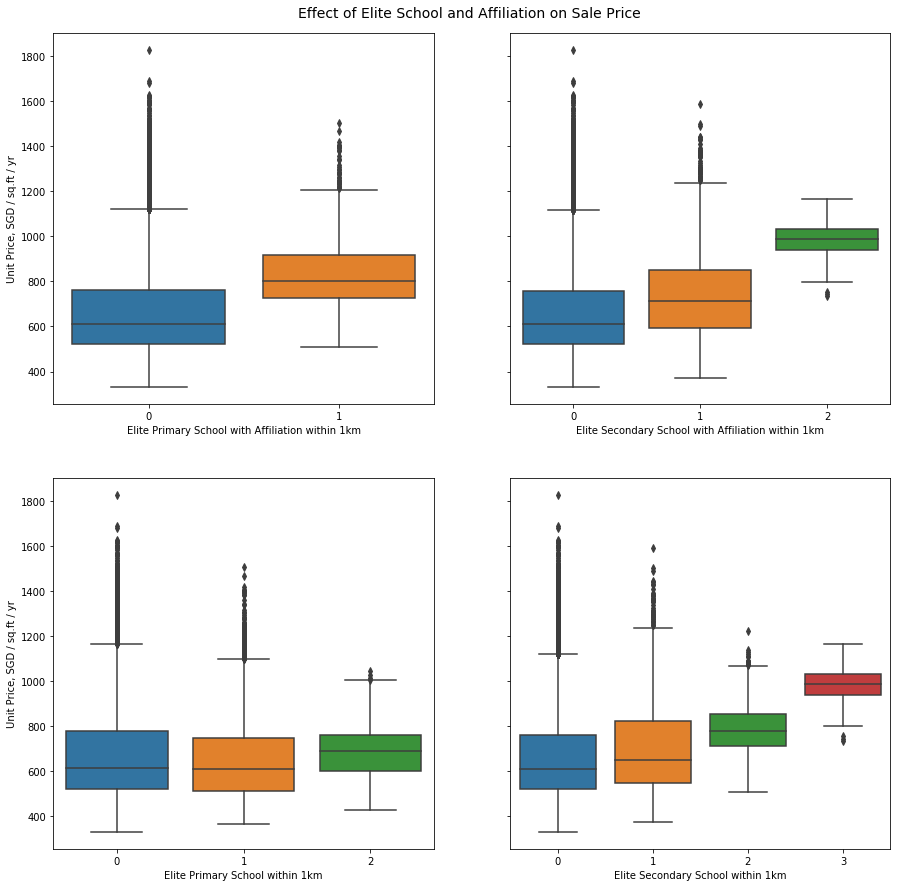

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 15), sharey=True)
ax = ax.ravel()

sns.boxplot(data=hdb, y='unit_price', x='pri_aff_u1km', ax=ax[0])
ax[0].set_xlabel("Elite Primary School with Affiliation within 1km")
ax[0].set_ylabel('Unit Price, SGD / sq.ft / yr')
ax[0].set_xticklabels([0, 1])

sns.boxplot(data=hdb, y='unit_price', x='sec_aff_u1km', ax=ax[1])
ax[1].set_xlabel("Elite Secondary School with Affiliation within 1km")
ax[1].set_ylabel('')
ax[1].set_xticklabels([0, 1, 2])

sns.boxplot(data=hdb, y='unit_price', x='pri_elite_u1km', ax=ax[2])
ax[2].set_xlabel("Elite Primary School within 1km")
ax[2].set_ylabel('Unit Price, SGD / sq.ft / yr')
ax[2].set_xticklabels([0, 1, 2])

sns.boxplot(data=hdb, y='unit_price', x='sec_elite_u1km', ax=ax[3])
ax[3].set_xlabel("Elite Secondary School within 1km")
ax[3].set_ylabel('')
ax[3].set_xticklabels([0, 1, 2, 3])

fig.suptitle("Effect of Elite School and Affiliation on Sale Price", fontsize=14, x=0.51, y=0.905)
plt.show()

If we take a look at the boxplots above, we can see that generally all of them have an effect on the housing price, except for Elite Primary School. There is certain degree of separation between the range for the other 3 features. As such, we will drop pri_elite_u1km from the dataset.

In [43]:
hdb.drop('pri_elite_u1km', axis=1, inplace=True)

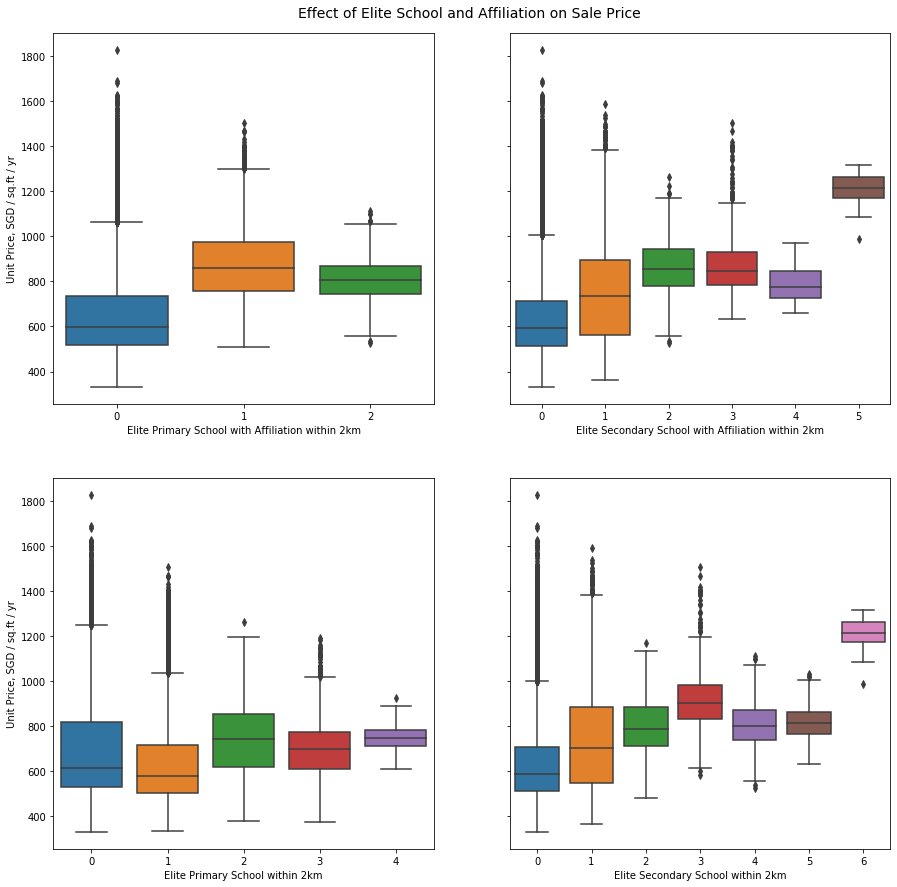

In [44]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 15), sharey=True)
ax = ax.ravel()

sns.boxplot(data=hdb, y='unit_price', x='pri_aff_u2km', ax=ax[0])
ax[0].set_xlabel("Elite Primary School with Affiliation within 2km")
ax[0].set_ylabel('Unit Price, SGD / sq.ft / yr')
ax[0].set_xticklabels(range(3))

sns.boxplot(data=hdb, y='unit_price', x='sec_aff_u2km', ax=ax[1])
ax[1].set_xlabel("Elite Secondary School with Affiliation within 2km")
ax[1].set_ylabel('')
ax[1].set_xticklabels(range(6))

sns.boxplot(data=hdb, y='unit_price', x='pri_elite_u2km', ax=ax[2])
ax[2].set_xlabel("Elite Primary School within 2km")
ax[2].set_ylabel('Unit Price, SGD / sq.ft / yr')
ax[2].set_xticklabels(range(5))

sns.boxplot(data=hdb, y='unit_price', x='sec_elite_u2km', ax=ax[3])
ax[3].set_xlabel("Elite Secondary School within 2km")
ax[3].set_ylabel('')
ax[3].set_xticklabels(range(7))

fig.suptitle("Effect of Elite School and Affiliation on Sale Price", fontsize=14, x=0.51, y=0.905)
plt.show()

As compared to the 1km scope, none of these 2km features has shown clear separation on the sale price. Most of the pattern are rather erratic, so we would drop all these 4 features.

In [45]:
hdb.drop(['pri_aff_u2km', 'sec_aff_u2km', 'pri_elite_u2km', 'sec_elite_u2km'], axis=1, inplace=True)

### 4.9 Highway Proximity

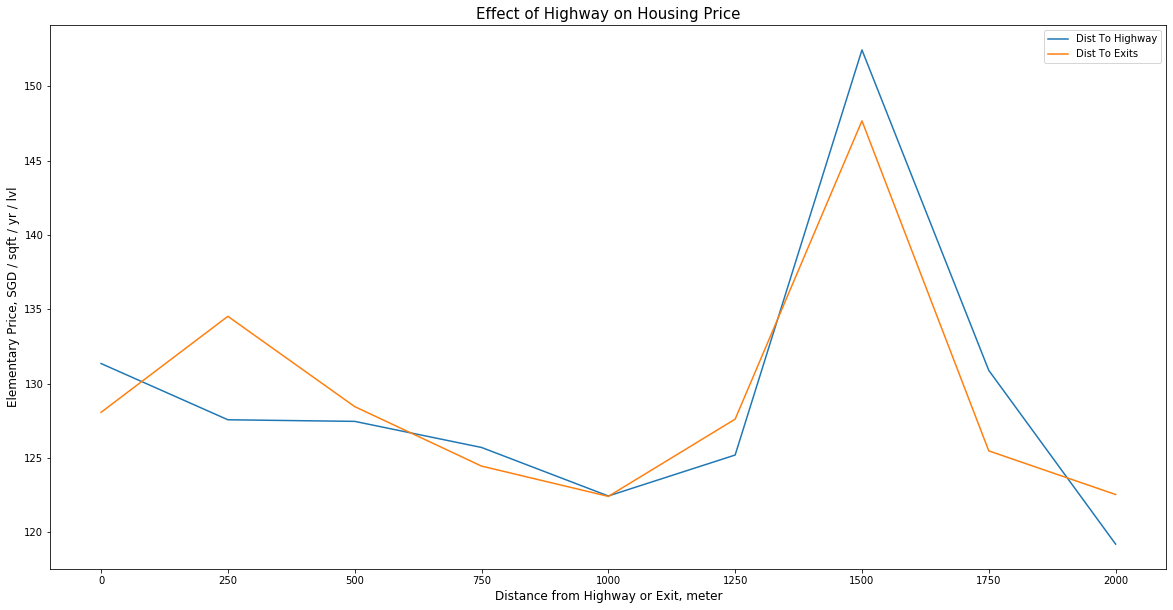

In [46]:
compound_line_plot(compound=250, x="dist_to_highway", x_2="dist_to_exits", y='elem_price', cutoff_point=2000,
                    x_label="Distance from Highway or Exit, meter", 
                    y_label="Elementary Price, SGD / sqft / yr / lvl", 
                    title="Effect of Highway on Housing Price")

In [47]:
hdb.corr()['resale_price'][['dist_to_highway', 'dist_to_exits']]

dist_to_highway   -0.141495
dist_to_exits     -0.130352
Name: resale_price, dtype: float64

From the figure above, we can see that the effect of property being near to highway is almost the same as being near to highway exit. Interestingly, the house prices peaked when the distance is about 1.5km away and dropped back down after that. It might due to the fact where being too close one would suffer from the noise; but being too far, it causes extra time to reach the highway. Since the 2 features are highly correlated, we will drop the one that has lower correlation to the resale price, which is distance to exits.

In [48]:
hdb.drop('dist_to_exits', axis=1, inplace=True)

### 4.10 Travel Time to Major Employment Center

In [49]:
def travel_line_plot(compound, x, x_2, y='price_per_sqft', df=hdb, x_label=None):
    fig, ax = plt.subplots(figsize=(20,10))
    
    temp = df.groupby(x).median()
    temp = temp.groupby(temp.index // compound).median().reset_index()[[x, y]]
    temp[x] = temp[x] * compound
    temp.set_index(x).plot(ax=ax)
    temp_2 = df.groupby(x_2).median()
    temp_2 = temp_2.groupby(temp_2.index // compound).median().reset_index()[[x_2, y]]
    temp_2[x_2] = temp_2[x_2] * compound
    temp_2.set_index(x_2).plot(ax=ax)
    ax.legend(['PT Transit Time, mins', 'Driving Time, mins'])

    plt.xlabel('Commuting Time, minutes', fontsize=12)
        
    plt.ylabel(y.replace('_', ' ').title(), fontsize=12)
    title = y + ' vs ' + x
    plt.title(title.replace('_', ' ').title(), fontsize=15)
    plt.show()

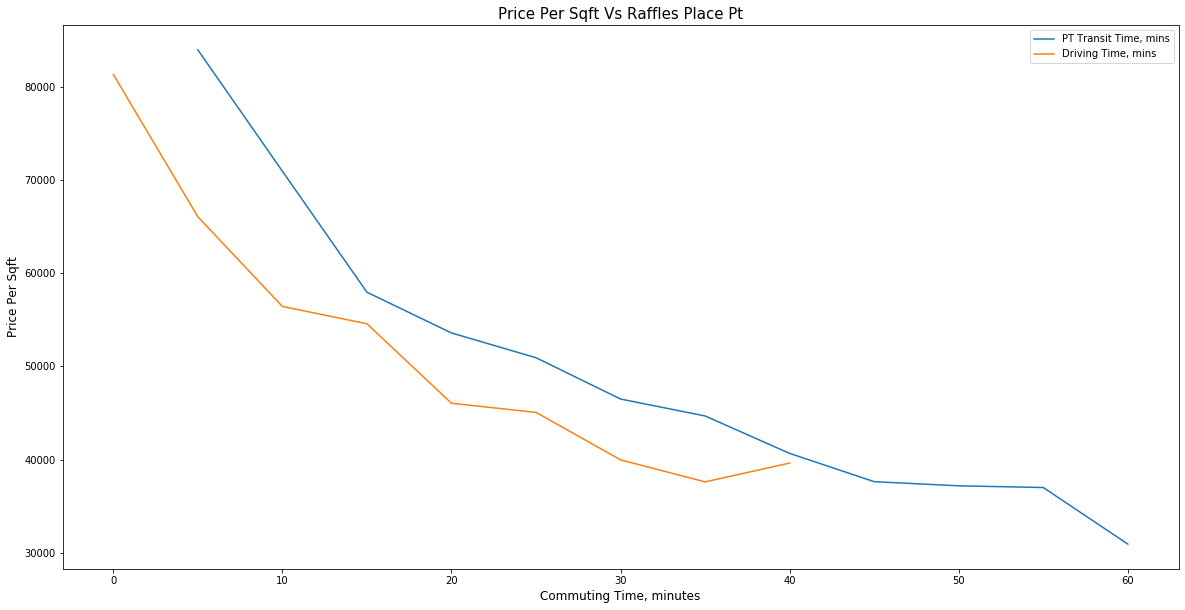

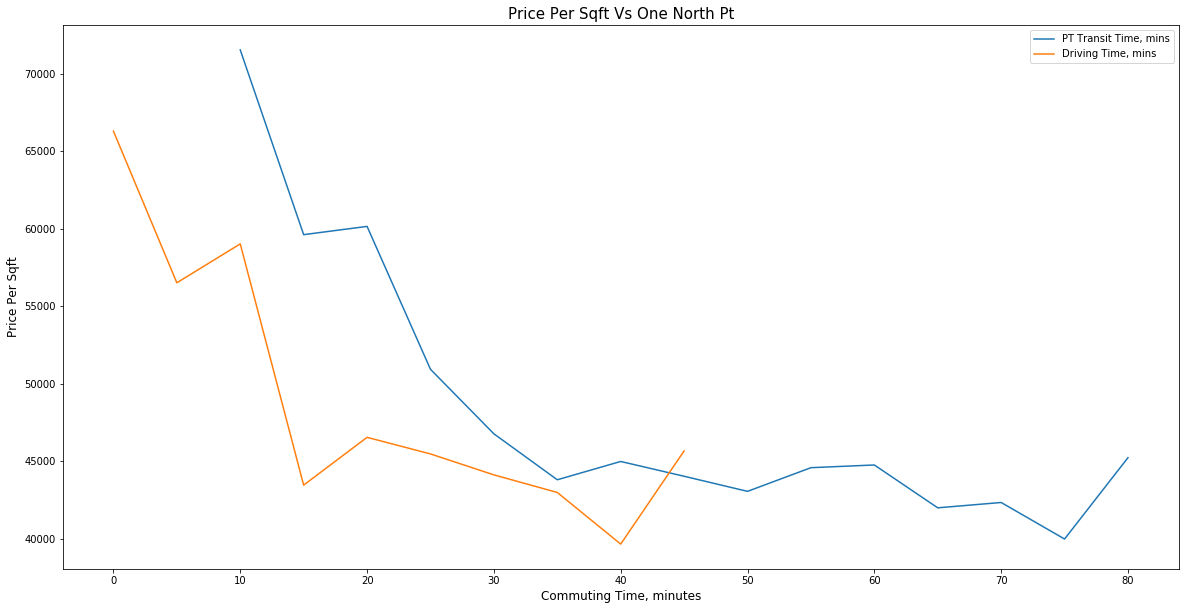

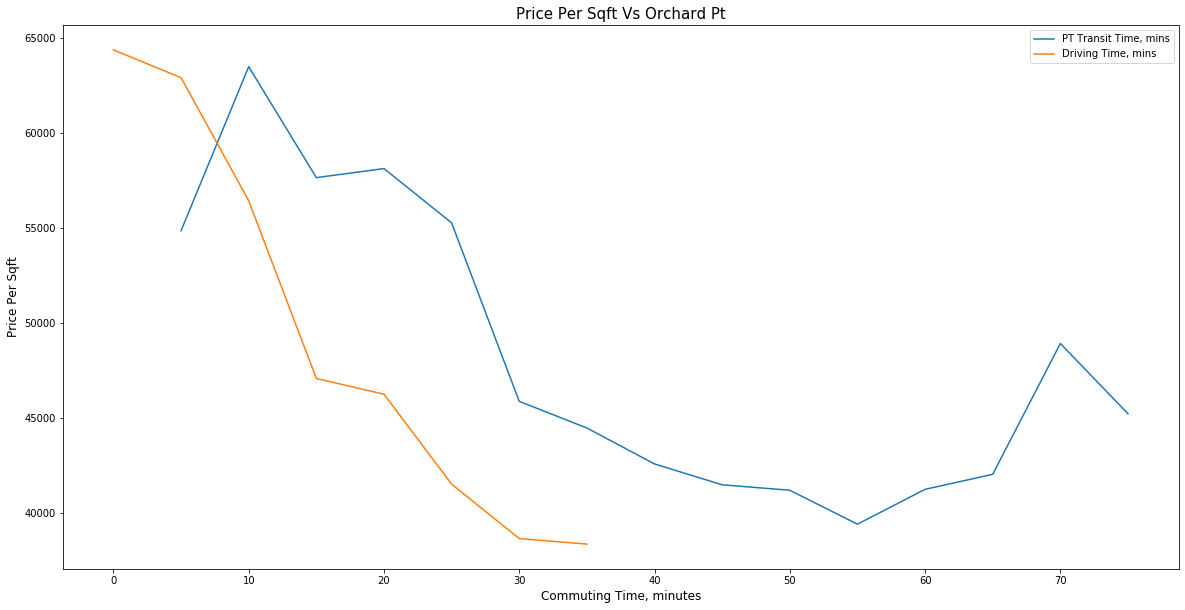

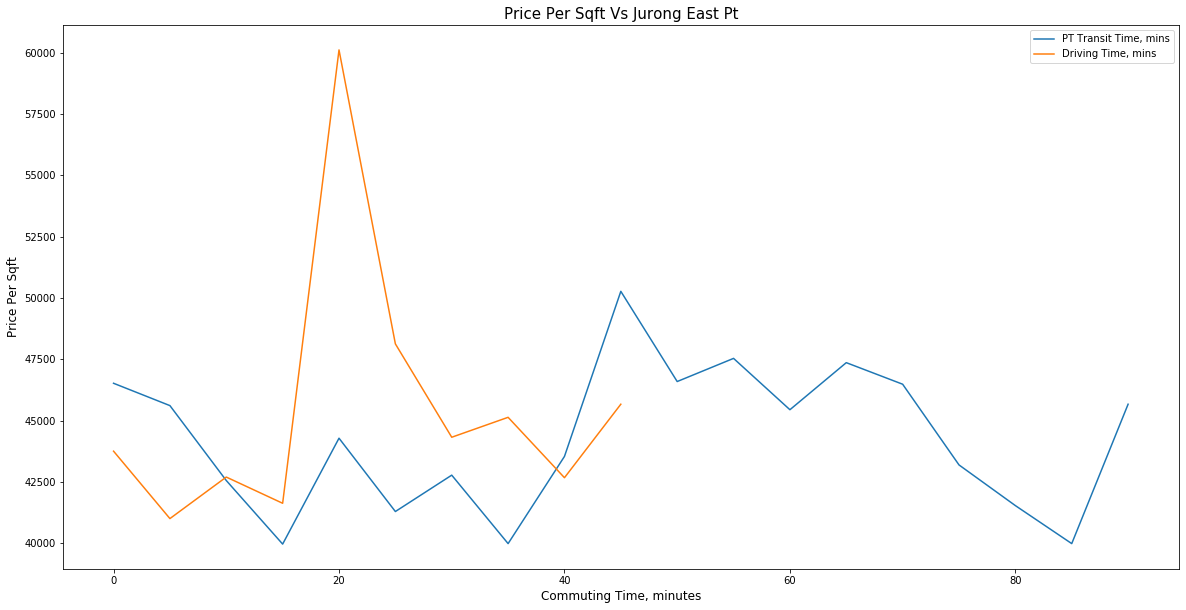

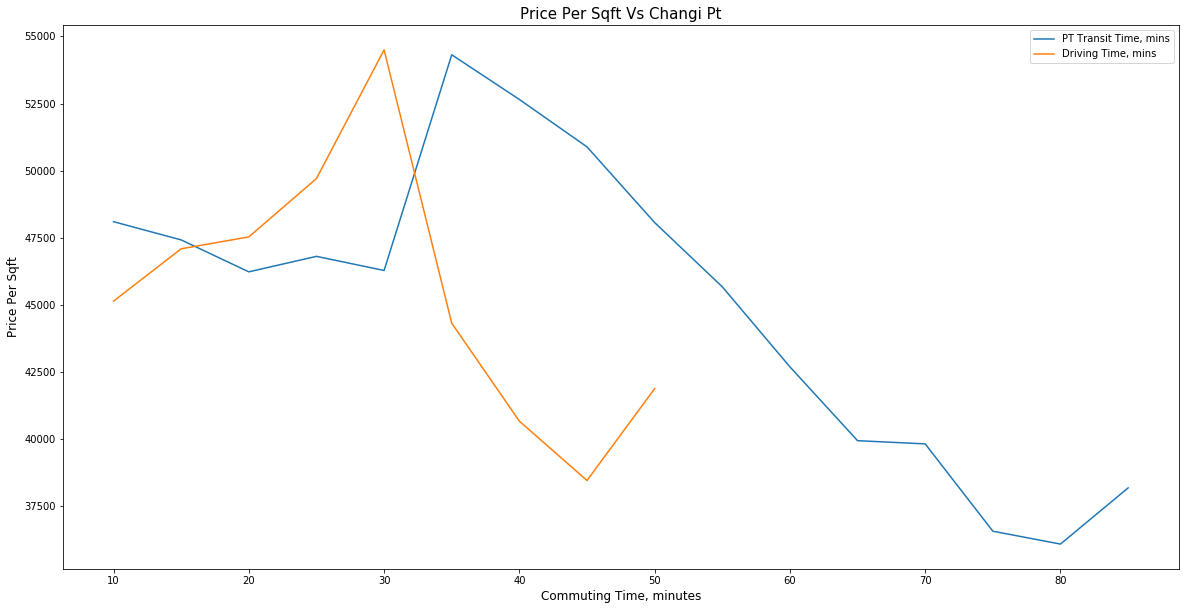

In [50]:
travel_line_plot(5, 'raffles_place_pt', x_2="raffles_place_drive")
travel_line_plot(5, 'one_north_pt', x_2="one_north_drive")
travel_line_plot(5, 'orchard_pt', x_2="orchard_drive")
travel_line_plot(5, 'jurong_east_pt', x_2="jurong_east_drive")
travel_line_plot(5, 'changi_pt', x_2="changi_drive")

We may notice one similarity among all of the 5 charts plotted above: driving time are almost cohere to the public transport commute, however with a slight delay of 5 to 10 minutes. However, public transport does have a higher range than driving and may explain better in term of variance of the sale price. Hence we would drop all driving time feature from the dataset to avoid collinearity. Apart from that, Jurong East doesn't seems to show any distinctive pattern and will also be dropped out.

In [51]:
hdb.drop(["raffles_place_drive", "one_north_drive", "orchard_drive", "jurong_east_drive", "changi_drive"], axis=1, inplace=True)
hdb.drop(["jurong_east_pt"], axis=1, inplace=True)

In [52]:
hdb.columns

Index(['town', 'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price', 'sold_year',
       'address', 'latitude', 'longitude', 'raffles_place_pt', 'one_north_pt',
       'orchard_pt', 'changi_pt', 'mrt_dist', 'mrt_station', 'mall_dist',
       'pri_u2km', 'pri_aff_u1km', 'sec_u2km', 'sec_aff_u1km',
       'sec_elite_u1km', 'dist_to_highway', 'price_per_sqft', 'unit_price',
       'elem_price'],
      dtype='object')

## 5. Mapping

Next up, we will plot 2 maps to showcase the effect of different features on property prices. One is plotted with the price per square feet scale, which is a common gauge of housing prices in the real estate industry. The other one is plotted with appeal score, a regional score that normalized the unit price of each property with accordance to the township it is situated. The appeal score ranges from 0 to 1, where 0 is the local minimum of a township and 1 is the local maximum.

Features such as schools, shopping malls and MRT stations are plotted in the map as well to observe the effect taken place in all different township. The features can be toggled on and off on the top right layer-control icon if you would like to switch between view.

In [53]:
# function to plot hexagon-lined map with pricing overlaid and amenities marked
def plot_hex_map(column):
    hexmap = folium.Map(location=[1.36, 103.83], zoom_start=12, tiles='stamen toner')
    folium.TileLayer('stamen toner').add_to(hexmap)
    folium.TileLayer('openstreetmap').add_to(hexmap)

    folium.Choropleth(
        name='Planning Area Boundaries',
        geo_data='./Dataset/Spatial/planning_area_optimized.geojson',
        fill_opacity=0,
        line_weight=2,
        line_opacity=1,
    ).add_to(hexmap)

    folium.Choropleth(
        name=column.replace('_', ' ').title(),
        geo_data='./Dataset/Spatial/hexmap.geojson',
        data=hex_df,
        columns=['hex_id', column],
        key_on='feature.properties.hex_id',
        fill_color='RdYlGn', 
        fill_opacity=0.6, 
        line_opacity=0.4,
        legend_name=column.replace('_', ' ').title(),
        nan_fill_color='white',
        nan_fill_opacity=0
    ).add_to(hexmap)

    school_fg = folium.FeatureGroup(name='Schools', show=False)

    for idx, (name, lat, lon) in enumerate(zip(pri['name'], pri['latitude'], pri['longitude'])):
        label = folium.Popup(f'{name} | Ranking: {idx+1}', parse_html=True, max_width=450)
        folium.Marker(
            [lat, lon],
            icon=folium.Icon(color='red', icon="book", prefix='fa'),
            popup=label).add_to(school_fg)

    for idx, (name, lat, lon) in enumerate(zip(sec['name'], sec['latitude'], sec['longitude'])):
        label = folium.Popup(f'{name} | Ranking: {idx+1}', parse_html=True, max_width=450)
        folium.Marker(
            [lat, lon],
            icon=folium.Icon(color='orange', icon="book", prefix='fa'),
            popup=label).add_to(school_fg)
        
    hexmap.add_child(school_fg)

    mrt_fg = folium.FeatureGroup(name='MRT Stations', show=False)

    for name, lat, lon in zip(mrt['Name'], mrt['Latitude'], mrt['Longitude']):
        label = folium.Popup(name + ' MRT', parse_html=True, max_width=450)
        folium.Marker(
            [lat, lon],
            icon=folium.Icon(icon="train", prefix='fa'),
            popup=label).add_to(mrt_fg)

    hexmap.add_child(mrt_fg)

    mall_fg = folium.FeatureGroup(name='Shopping Malls', show=False)

    for name, lat, lon in zip(spm['name'], spm['latitude'], spm['longitude']):
        label = folium.Popup(name, parse_html=True, max_width=450)
        folium.Marker(
            [lat, lon],
            icon=folium.Icon(color='green', icon="shopping-cart"),
            popup=label).add_to(mall_fg)

    hexmap.add_child(mall_fg)

    folium.LayerControl(collapsed=True).add_to(hexmap)

    return hexmap

In [54]:
plot_hex_map('price_per_sqft')

From the map above, we can see that the price per sqft generally fell as the property gets further away from the city center located at the South-end of the island. However, we may still notice some local maximum at each suburban township, but they are far from being distinct enough to be observed any pattern. 

The problem with observation at suburban is what gave rise to the introduction of appeal score. In the next map, we would magnify into each township to see the effect of amenities on the property pricing with the help of appeal score.

In [55]:
plot_hex_map('appeal_score')

Now, it became more apparent with the regional distribution of property value and the effect of various amenities on the value. MRT seems to be the biggest factor in contributing to the property value. High proportion of Singapore workforce travel to work by public transport, so it is not surprising that home buyer is willing to pay the premium to stay close to a train station, which could save them significant time in the long run for daily commute.

## 6. Feature Engineering

In [56]:
# Normalize time to the year of 2016 so the minimum became 1
hdb['sold_year'] = hdb['sold_year'] - 2016

In [57]:
hdb.columns

Index(['town', 'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price', 'sold_year',
       'address', 'latitude', 'longitude', 'raffles_place_pt', 'one_north_pt',
       'orchard_pt', 'changi_pt', 'mrt_dist', 'mrt_station', 'mall_dist',
       'pri_u2km', 'pri_aff_u1km', 'sec_u2km', 'sec_aff_u1km',
       'sec_elite_u1km', 'dist_to_highway', 'price_per_sqft', 'unit_price',
       'elem_price'],
      dtype='object')

In [58]:
# Drop off column that contribute nothing to the model or might represent noise
# Flat model is dropped to facilitate deployment which is usually unknown to the general home buyer
hdb.drop(['address', 'flat_model', 'latitude', 'longitude', 'lease_commence_date', 'mrt_station'],
         axis=1, inplace=True)

In [59]:
# Drop off all price metrics to avoid data leakage
hdb.drop(['price_per_sqft', 'unit_price', 'elem_price'], axis=1, inplace=True)

In [60]:
hdb.columns

Index(['town', 'storey_range', 'floor_area_sqm', 'remaining_lease',
       'resale_price', 'sold_year', 'raffles_place_pt', 'one_north_pt',
       'orchard_pt', 'changi_pt', 'mrt_dist', 'mall_dist', 'pri_u2km',
       'pri_aff_u1km', 'sec_u2km', 'sec_aff_u1km', 'sec_elite_u1km',
       'dist_to_highway'],
      dtype='object')

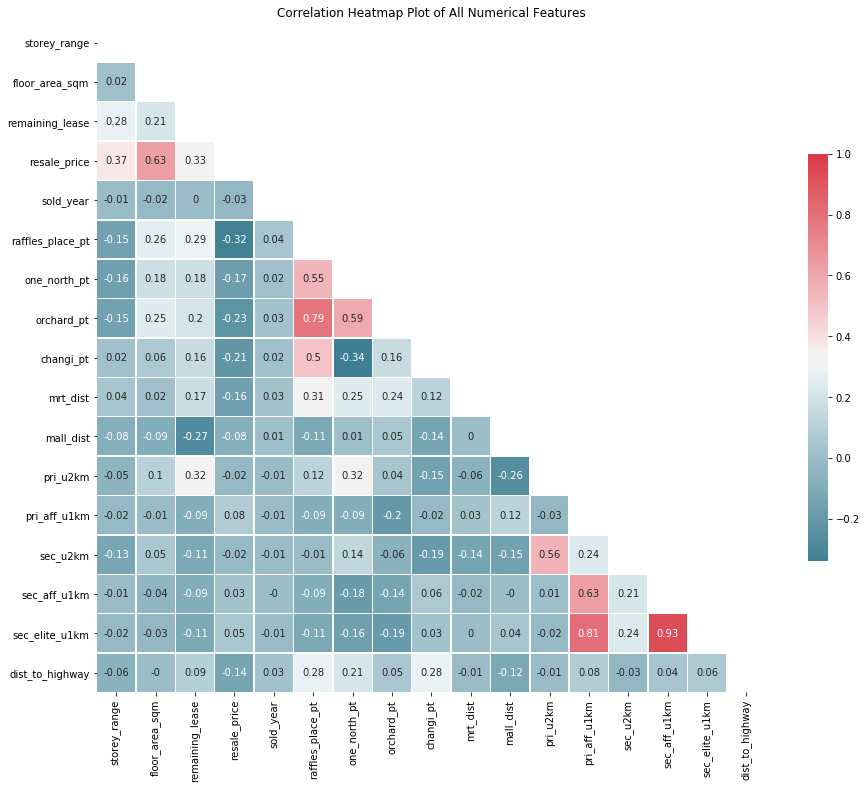

In [61]:
# Plotting correlation heatmap
corr = round(hdb.corr(),2)
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, square=True, annot=True, mask=mask, cmap=cmap, 
            linewidths=.5, cbar_kws={'shrink':0.5})
plt.title('Correlation Heatmap Plot of All Numerical Features')
plt.show()

As shown in the correlation heatmap above, there are still several features that suffers from high collinearity. These collinear features would contribute relatively little to the model accuracy and low cardinality ensures an optimal model. Hence, all of the collinear features with Pearson's correlation of more than 0.75 will be dropped automatically from the dataset.

In [62]:
# Drop off any collinear columns
correlated_features = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.75:
            colname = corr.columns[i]
            correlated_features.add(colname)

print("Collinear Columns to drop: ", correlated_features)

hdb.drop(correlated_features, axis=1, inplace=True)

Collinear Columns to drop:  {'orchard_pt', 'sec_elite_u1km'}


In [63]:
# Select only key feature that is correlated to the resale price
correlation = hdb.corr()['resale_price']
key_feature = correlation[np.abs(correlation)>0.05].index

In [64]:
key_feature

Index(['storey_range', 'floor_area_sqm', 'remaining_lease', 'resale_price',
       'raffles_place_pt', 'one_north_pt', 'changi_pt', 'mrt_dist',
       'mall_dist', 'pri_aff_u1km', 'dist_to_highway'],
      dtype='object')

In [65]:
# Define X and y
X = hdb[list(key_feature) + ['town']].drop('resale_price', axis=1)
y = hdb['resale_price']

Next up, for validation of our model, we will split our into train and test sets. 20% of the most recent data will be testset. Shuffle is disabled to test the resilience of the machine learning model in predicting future housing price based on historical data.

In [66]:
# Train-test split to assess model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [67]:
print("Index Range of Trainset: ", min(X_train.index), '-', max(X_train.index))

Index Range of Trainset:  0 - 56049


In [68]:
print("Index Range of Testset: ", min(X_test.index), '-', max(X_test.index))

Index Range of Testset:  56050 - 70062


In [69]:
len(X_train.columns)

11

In [70]:
X_train.columns

Index(['storey_range', 'floor_area_sqm', 'remaining_lease', 'raffles_place_pt',
       'one_north_pt', 'changi_pt', 'mrt_dist', 'mall_dist', 'pri_aff_u1km',
       'dist_to_highway', 'town'],
      dtype='object')

In [71]:
# One-hot encoding for township
X_train_new = pd.get_dummies(X_train, drop_first=False)
X_test_new = pd.get_dummies(X_test, drop_first=False)

In [72]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train_new)
X_test_sc = ss.transform(X_test_new)

## 7. Modelling

### 7.1 Linear Regression

#### 7.1.1 Multiple Linear Regression (MLR)

In [73]:
lr = LinearRegression()
lr.fit(X_train_new, y_train)

print("Multiple Linear Regression\n")
print("R2 Train :", round(cross_val_score(lr, X_train_new, y_train, cv=10).mean(), 3))
print("R2 Test  :", round(lr.score(X_test_new, y_test), 3))
print("RMSE Test: $", int(mean_squared_error(y_test, lr.predict(X_test_new), squared=False)))
print("MAE Test : $", int(mean_absolute_error(y_test, lr.predict(X_test_new))))

Multiple Linear Regression

R2 Train : 0.879
R2 Test  : 0.868
RMSE Test: $ 54629
MAE Test : $ 41415


From the metrics above, we can see that the trainset has a higher R2 score than the testset, which means the model is slightly overfitted. So we would try to use Ridge and Lasso regression to hopefully be able to close the gap by normalizing the features.

In [74]:
# Coefficient of features
pd.Series(lr.coef_, X_train_new.columns).sort_values()

town_CHOA CHU KANG     -155166.317029
town_SEMBAWANG         -137683.712362
town_JURONG WEST       -120005.551957
town_WOODLANDS          -96667.397477
town_BUKIT PANJANG      -94845.108515
town_SENGKANG           -92490.602527
town_BUKIT BATOK        -82245.976114
town_PUNGGOL            -81189.872868
town_YISHUN             -53582.853784
town_JURONG EAST        -52864.314599
town_HOUGANG            -46599.430210
one_north_pt             -2846.784013
raffles_place_pt         -1818.328750
pri_aff_u1km              -414.199556
mrt_dist                   -39.660459
changi_pt                  -20.240685
mall_dist                  -12.768410
dist_to_highway              6.266817
floor_area_sqm            4420.482617
town_PASIR RIS            4576.159636
storey_range              4802.171405
remaining_lease           4954.762999
town_CLEMENTI             9488.035808
town_ANG MO KIO          23850.823309
town_SERANGOON           30870.646013
town_QUEENSTOWN          32690.132184
town_TAMPINE

If we take a look at the coefficient for each features, it's not hard to see that the model is dominated by the township feature. However, it is not very good for inference because knowing which town cost higher does not answer the problem statement that we set out on. Home buyer does not just buy a home based on the township where it is located, there must be other factors that are more quantifiable in the decision making process. These inference will be looked in detail at Section 8 where we take away the effect of township.

#### 7.1.2 Ridge Regression

In [75]:
ridge = RidgeCV(alphas=np.logspace(-1, 4, 50))
ridge.fit(X_train_sc, y_train)

print("Lasso Regression\n")
print("Best Alpha:", ridge.alpha_)
print("R2 Train  :", round(cross_val_score(ridge, X_train_sc, y_train, cv=10).mean(), 3))
print("R2 Test   :", round(ridge.score(X_test_sc, y_test), 3))
print("RMSE Test : $", int(mean_squared_error(y_test, ridge.predict(X_test_sc), squared=False)))
print("MAE Test  : $", int(mean_absolute_error(y_test, ridge.predict(X_test_sc))))

Lasso Regression

Best Alpha: 3.39322177189533
R2 Train  : 0.879
R2 Test   : 0.868
RMSE Test : $ 54630
MAE Test  : $ 41415


#### 7.1.3 Lasso Regression

In [76]:
lasso = LassoCV(alphas=np.linspace(0.01, 1, 50), max_iter=10_000, random_state=42)
lasso.fit(X_train_sc, y_train)

print("Lasso Regression\n")
print("Best Alpha:", lasso.alpha_)
print("R2 Train  :", round(cross_val_score(lasso, X_train_sc, y_train, cv=10).mean(), 3))
print("R2 Test   :", round(lasso.score(X_test_sc, y_test), 3))
print("RMSE Test : $", int(mean_squared_error(y_test, lasso.predict(X_test_sc), squared=False)))
print("MAE Test  : $", int(mean_absolute_error(y_test, lasso.predict(X_test_sc))))

Lasso Regression

Best Alpha: 1.0
R2 Train  : 0.879
R2 Test   : 0.868
RMSE Test : $ 54629
MAE Test  : $ 41415


Unfortunately, neither lasso or ridge regression has seen any improvement in the R2 score of testset. In fact, the scores and error are exactly the same as the MLR.

### 7.2 Random Forest Regressor

Random forest deploys multiple decision tree as estimator for prediction, however, its performance is heavily influenced by the hyperparameters such as depth of tree, features to be considered, number of estimators etc. Gridsearch is used for this case to find out the best parameters by iterating through all possible permutation. The code below has only 1 choice for each parameters because only the best params is left to speed up re-running of the code. The process of hyperparameter tuning is purely empirical and trial and error was the only option.

In [77]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_params = {
    'max_depth': [40],
    'max_features': [17],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
    'n_estimators': [200]
}

gs = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5)
gs.fit(X_train_new, y_train)

print("Random Forest Regressor\n")
print("R2 Train  :", round(gs.best_score_, 3))
print("R2 Test   :", round(gs.score(X_test_new, y_test), 3))
print("RMSE Test : $", int(mean_squared_error(y_test, gs.predict(X_test_new), squared=False)))
print("MAE Test  : $", int(mean_absolute_error(y_test, gs.predict(X_test_new))))

Random Forest Regressor

R2 Train  : 0.967
R2 Test   : 0.952
RMSE Test : $ 32982
MAE Test  : $ 21661


It seems that the random forest regressor has outperformed the linear regression by close to 10% improvement in R2 scoring.

### 7.3 Neural Network

Next, we will put neural network in trial in the hope that it might break the glass ceiling of the R2 score. In the model, we are using 4 hidden layers (all with ReLu activation) and 1 linear output layer. Early stopping was deployed to the model upon convergence of MSE.

In [78]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto')

model = Sequential()
model.add(Dense(64, input_shape=(X_train_new.shape[1],), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_sc, y_train, epochs=30, batch_size=128, validation_data=(X_test_sc, y_test), 
                    callbacks=early_stop, verbose=1)

Epoch 1/30
438/438 [==============================] - 2s 5ms/step - loss: 50928590848.0000 - val_loss: 2485800192.0000
Epoch 2/30
438/438 [==============================] - 2s 5ms/step - loss: 1963850240.0000 - val_loss: 1976627200.0000
Epoch 3/30
438/438 [==============================] - 2s 5ms/step - loss: 1681157888.0000 - val_loss: 1784821120.0000
Epoch 4/30
438/438 [==============================] - 2s 4ms/step - loss: 1555314048.0000 - val_loss: 1787236992.0000
Epoch 5/30
438/438 [==============================] - 2s 4ms/step - loss: 1476630784.0000 - val_loss: 1671344512.0000
Epoch 6/30
438/438 [==============================] - 1s 3ms/step - loss: 1427026304.0000 - val_loss: 1664695680.0000
Epoch 7/30
438/438 [==============================] - 1s 3ms/step - loss: 1387448320.0000 - val_loss: 1647908480.0000
Epoch 8/30
438/438 [==============================] - 1s 2ms/step - loss: 1361614336.0000 - val_loss: 1699576192.0000
Epoch 9/30
438/438 [==============================] - 1

In [79]:
print("Neural Network Regressor\n")
print("R2 Train  :", round(r2_score(y_train, model.predict(X_train_sc)), 3))
print("R2 Test   :", round(r2_score(y_test, model.predict(X_test_sc)), 3))
print("RMSE Test : $", int(mean_squared_error(y_test, model.predict(X_test_sc), squared=False)))
print("MAE Test  : $", int(mean_absolute_error(y_test, model.predict(X_test_sc))))

Neural Network Regressor

R2 Train  : 0.946
R2 Test   : 0.931
RMSE Test : $ 39474
MAE Test  : $ 28291


Apparently Neural Network has not been able to break the record set by Random Forest Regressor, however it did performed better than the MLR model. As such, we will export the random forest model for web deployment purpose.

### 7.4 Export of Model for Deployment

In this section, we will retrain the model with all of the data that we have for deployment so we can make use of all the information available. However, to speed up the processing speed for deployment, all columns involving travel time and distance to highway will be dropped because calling multiple external API could slow the web-app down tremendously. After these columns are dropped, the random forest model will be retrained with new set of hyper-parameters to ensure not too much of the accuracy is compromised.

In [80]:
columns = [col for col in X_train_new.columns if '_pt' not in col]
columns.remove('dist_to_highway')

In [81]:
X_train_exp = X_train_new[columns]
X_test_exp = X_test_new[columns]

In [82]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_params = {
    'max_depth': [50],
    'max_features': [15],
    'min_samples_leaf': [2],
    'min_samples_split': [5],
    'n_estimators': [250]
}

gs = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5)
gs.fit(X_train_exp, y_train)

print("Random Forest Regressor\n")
print("R2 Train  :", round(gs.best_score_, 3))
print("R2 Test   :", round(gs.score(X_test_exp, y_test), 3))
print("RMSE Test : $", int(mean_squared_error(y_test, gs.predict(X_test_exp), squared=False)))
print("MAE Test  : $", int(mean_absolute_error(y_test, gs.predict(X_test_exp))))

Random Forest Regressor

R2 Train  : 0.962
R2 Test   : 0.948
RMSE Test : $ 34180
MAE Test  : $ 23012


Here we see that we have lost very minimal accuracy from the previous random forest, so most variance can still be explained with much lesser columns. Now we will export the model for the backend of the web-app to use and predict the estimated prices.

In [83]:
# Re-training with entire dataset
X_final = pd.concat([X_train_exp, X_test_exp])

# Random Forest with the best params
rf_final = RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=50, max_features=15,
                                 min_samples_leaf=2, min_samples_split=5, n_estimators=250)
rf_final.fit(X_final, y)

# Final check on the cross val score
cross_val_score(rf_final, X_final, y, cv=5, n_jobs=-1).mean()

0.9611483970191756

In [84]:
[col for col in X_final.columns if 'town_' not in col]

['storey_range',
 'floor_area_sqm',
 'remaining_lease',
 'mrt_dist',
 'mall_dist',
 'pri_aff_u1km']

In [85]:
joblib.dump(rf_final, './Deployment/data/final_model.pkl')

['../Deployment/data/final_model.pkl']

## 8. Statistical Inferences

As mentioned before, by including township in the model, we could not actually come out with extensive statistical inference. A certain township is more expensive than the others was probably because of the geographical advantages a certain area possesses or its proximity to major employment center or even the local community composition.

In this section, we seek to find out more about the reasonings by removing township from the equation that builds up our model.

In [86]:
X = hdb.drop(['town', 'resale_price'], axis=1)
y = hdb['resale_price']
lr = LinearRegression()
lr.fit(X, y)
cross_val_score(lr, X, y, cv=10).mean()

0.8287149830788664

In [87]:
pd.Series(lr.coef_, X.columns).sort_values()

pri_u2km            -8385.518788
raffles_place_pt    -5972.338647
changi_pt           -1380.652651
one_north_pt        -1251.400809
mrt_dist              -28.541668
mall_dist              -2.315865
dist_to_highway         1.174806
sold_year             720.501306
sec_aff_u1km          755.341579
floor_area_sqm       4404.789589
remaining_lease      4569.635364
sec_u2km             4727.448198
storey_range         5056.609293
pri_aff_u1km        53100.161741
dtype: float64

From the computation result of the model performance above, we have managed to achieve only 82.9% as compared to the original 87.2% in term of R2 score. That would means that even with geographical features such as amenities and infrastructure, there are still 4.3% of the variance that the new model cannot explain without township.

As expected, floor area, storey range and remaining lease continues to top the ranking. Nevertheless, primary school with affiliation to elite secondary school seems to have played a critical role too, each of which would add on 53,100 SGD to the price tag of a HDB flat. Surprisingly enough, the number of primary school within a 2km radius turned out to be a negative factor while secondary school being a positive factor.

With contrast to the chart that plotted earlier on, which has shown that the price has dropped slight year by year, the model has shown the effect to be the opposite, at 720 SGD per year. If we take a look at the commuting time from the 3 employment center that remains in the model, Raffles Place (the city center) clearly stands out as the top contributing factor. For every minutes it takes you to get to Raffles Place, the house value would drop by 5,972 SGD. The effect is actually extremely significant considering the common time spent on commuting to city is about 15 to 30 minutes from township that are neighbouring the city center.

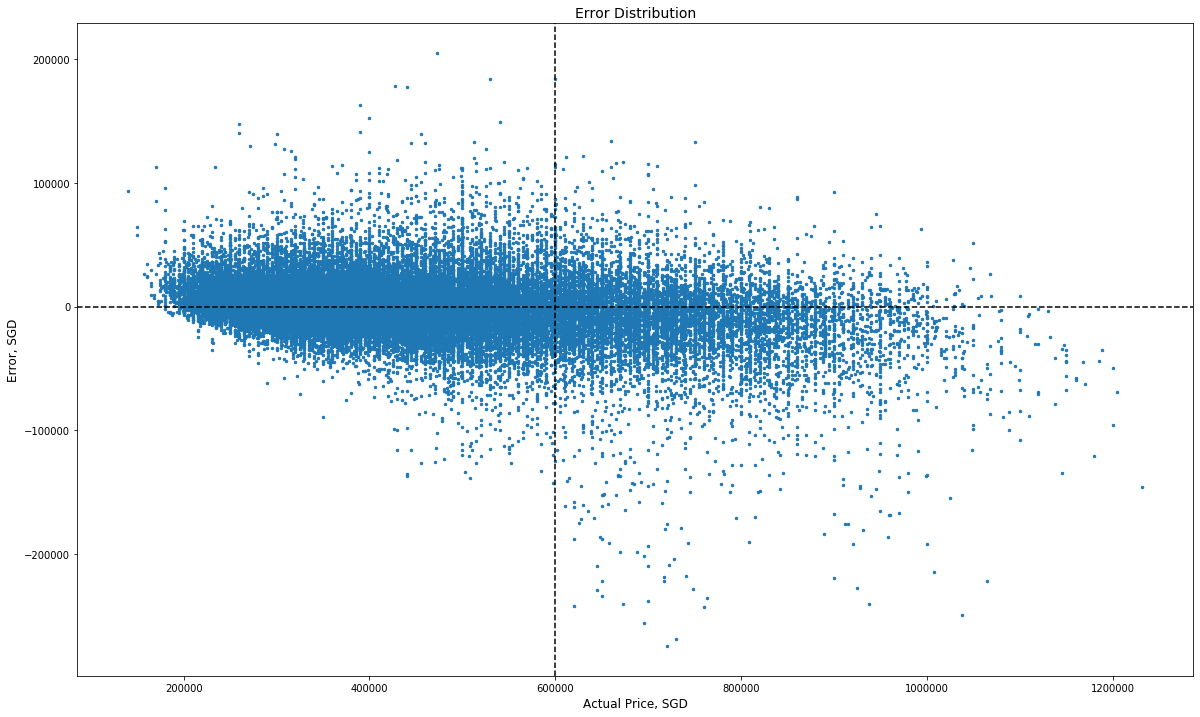

In [106]:
yhat = gs.predict(pd.concat([X_train_exp, X_test_exp]))
plt.figure(figsize=(20,12))
plt.scatter(y, yhat - y, s=6)
plt.axhline(0, color='k', ls='--')
plt.axvline(600_000, color='k', ls='--')
plt.title("Error Distribution", fontsize=14)
plt.xlabel("Actual Price, SGD", fontsize=12)
plt.ylabel("Error, SGD", fontsize=12)
plt.show()

Now if we take a look at the error distribution, we could see for most of the dataset could actually be predicted accurately. However, there are several property that cost more than 600,000 SGD were being undervalued significantly. There are definitely limitation to our model as resale flat might come in different furnishing level, or condition of the house might vary across a wide range too. We have no way to find out about the house condition and thus unable to capture one of the most critical factor in property pricing. Nevertheless, for most part, the model is extremely accurate, up to 23,012 SGD as inferred by the Mean Absolute Error of our final deployable model.

## 9. Conclusion

In all, we have successfully developed and deployed a machine learning model to predict the pricing of resale HDB flats in Singapore. The accuracy was even up to 95% with the use of Random Forest Regressor. We have also found that the key indicators for price prediction are actually Floor Area, Remaining Year Lease, Storey Range and the Township where the property is situated. However, if we were to take away the effect of Township, we would still be able to explain some of its variance with the help of commuting time from the CBD, one-north and Changi airport.

Although HDB-developed flats are in a highly controlled environment where investment would only yield unexciting profit, this project still serve as a window to look into home buyer's psychology and how premium is justifiable by numerical features or attributes. Hence the same methodology could still be applied to Condominium sales in Singapore or real estates in City States that resembles Singapore where some of the key features could still be applicable and worth researching.

To access the web application that was developed using the final model we created through the project, please visit https://hdb-appraiser.herokuapp.com.